Figure 3a

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
# read excel
excel_file = pd.ExcelFile(r'overall.xlsx')
sheet_names = excel_file.sheet_names
sheet_names
df = excel_file.parse('Sheet1')

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
C:\Users\SSL\AppData\Local\Temp\ipykernel_6152\3207734446.py:39: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, color='orangered', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))


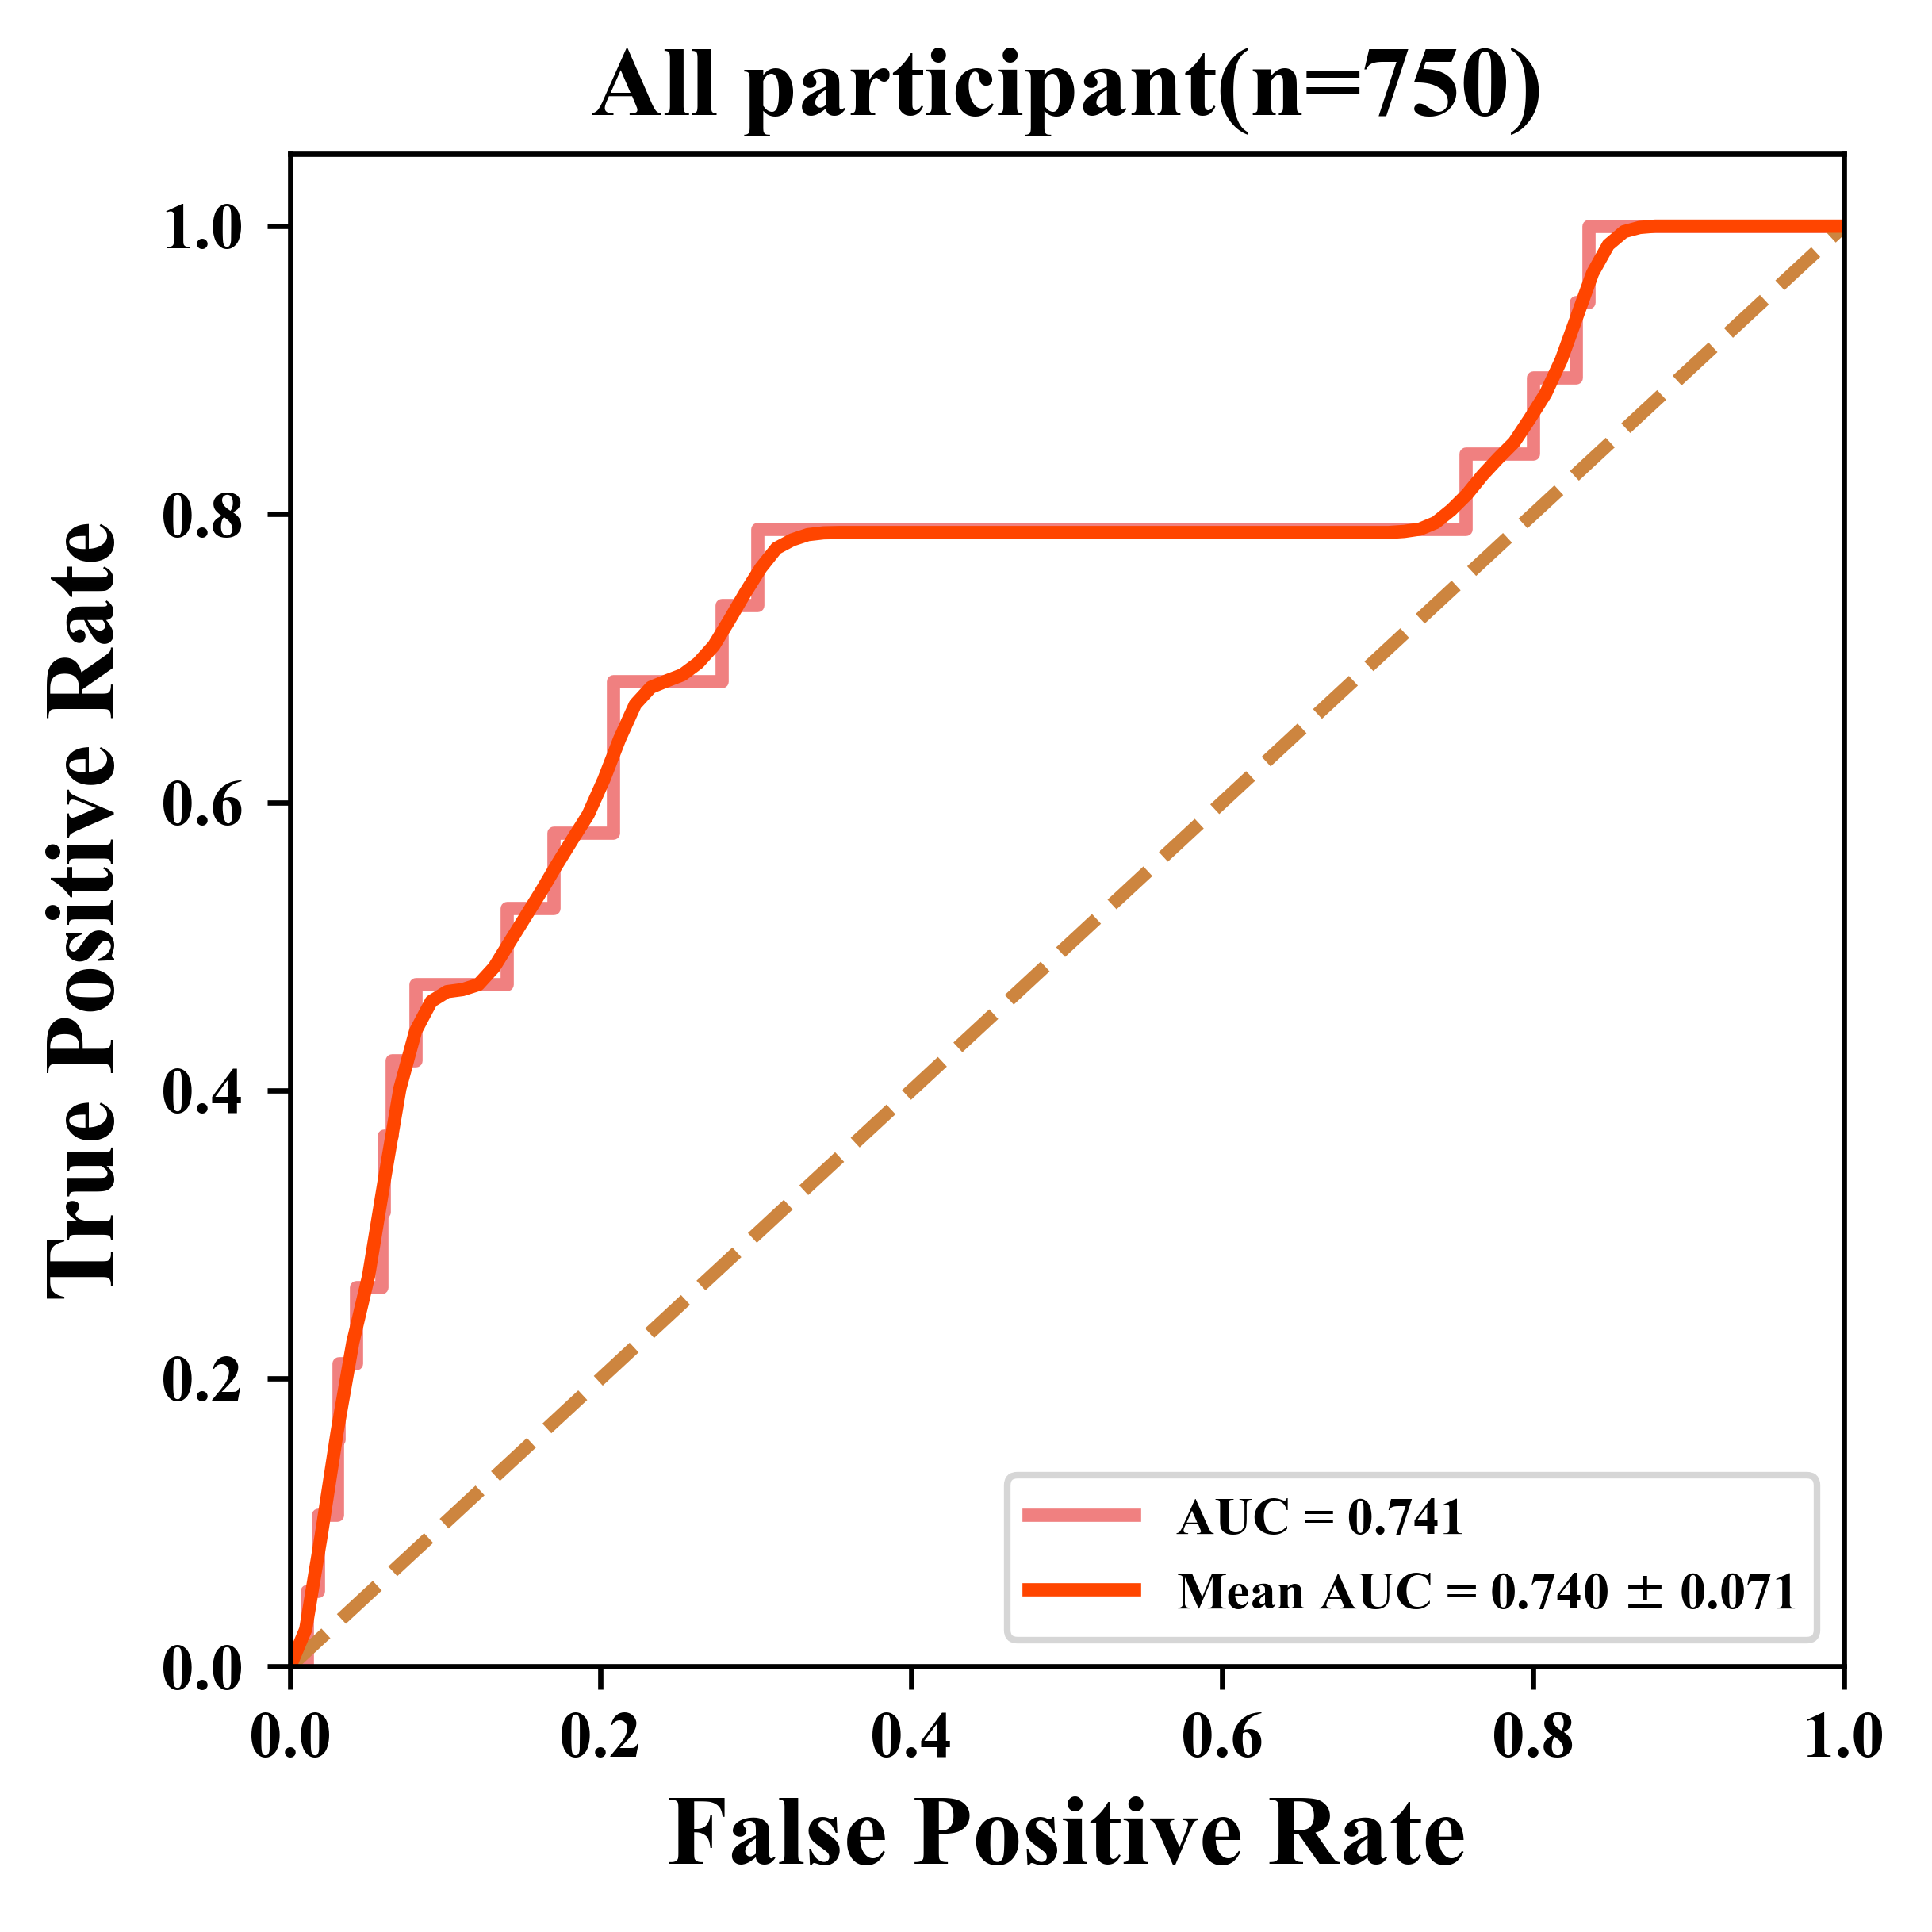

In [6]:
np.random.seed(2025)
plt.figure(figsize=(4, 4),dpi=600)
fpr, tpr, _ = roc_curve(df['al'], df['pres_proba'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='lightcoral', lw=2, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='peru', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.ylabel('True Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.xticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.yticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.title('All participant(n=750)',fontproperties = 'Times New Roman',fontsize = 15,weight='bold')
plt.legend(loc='lower right')

# bootstrap 
n_bootstraps = 1000
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(n_bootstraps):
    indices = resample(np.arange(len(df['al'])))
    fpr_bs, tpr_bs, _ = roc_curve(df['al'].iloc[indices], df['pres_proba'].iloc[indices])
    roc_auc_bs = auc(fpr_bs, tpr_bs)
    interp_tpr = np.interp(mean_fpr, fpr_bs, tpr_bs)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc_bs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# 95%CI
lower_bound = np.percentile(aucs, 2.5)
upper_bound = np.percentile(aucs, 97.5)

plt.plot(mean_fpr, mean_tpr, color='orangered', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))
fontdict_prop = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 8,
}
plt.legend(loc="lower right",prop=fontdict_prop)
plt.tight_layout(pad=0.5)
#plt.savefig(r"allroc.jpg",dpi=600)
plt.show() 

Figure 3b

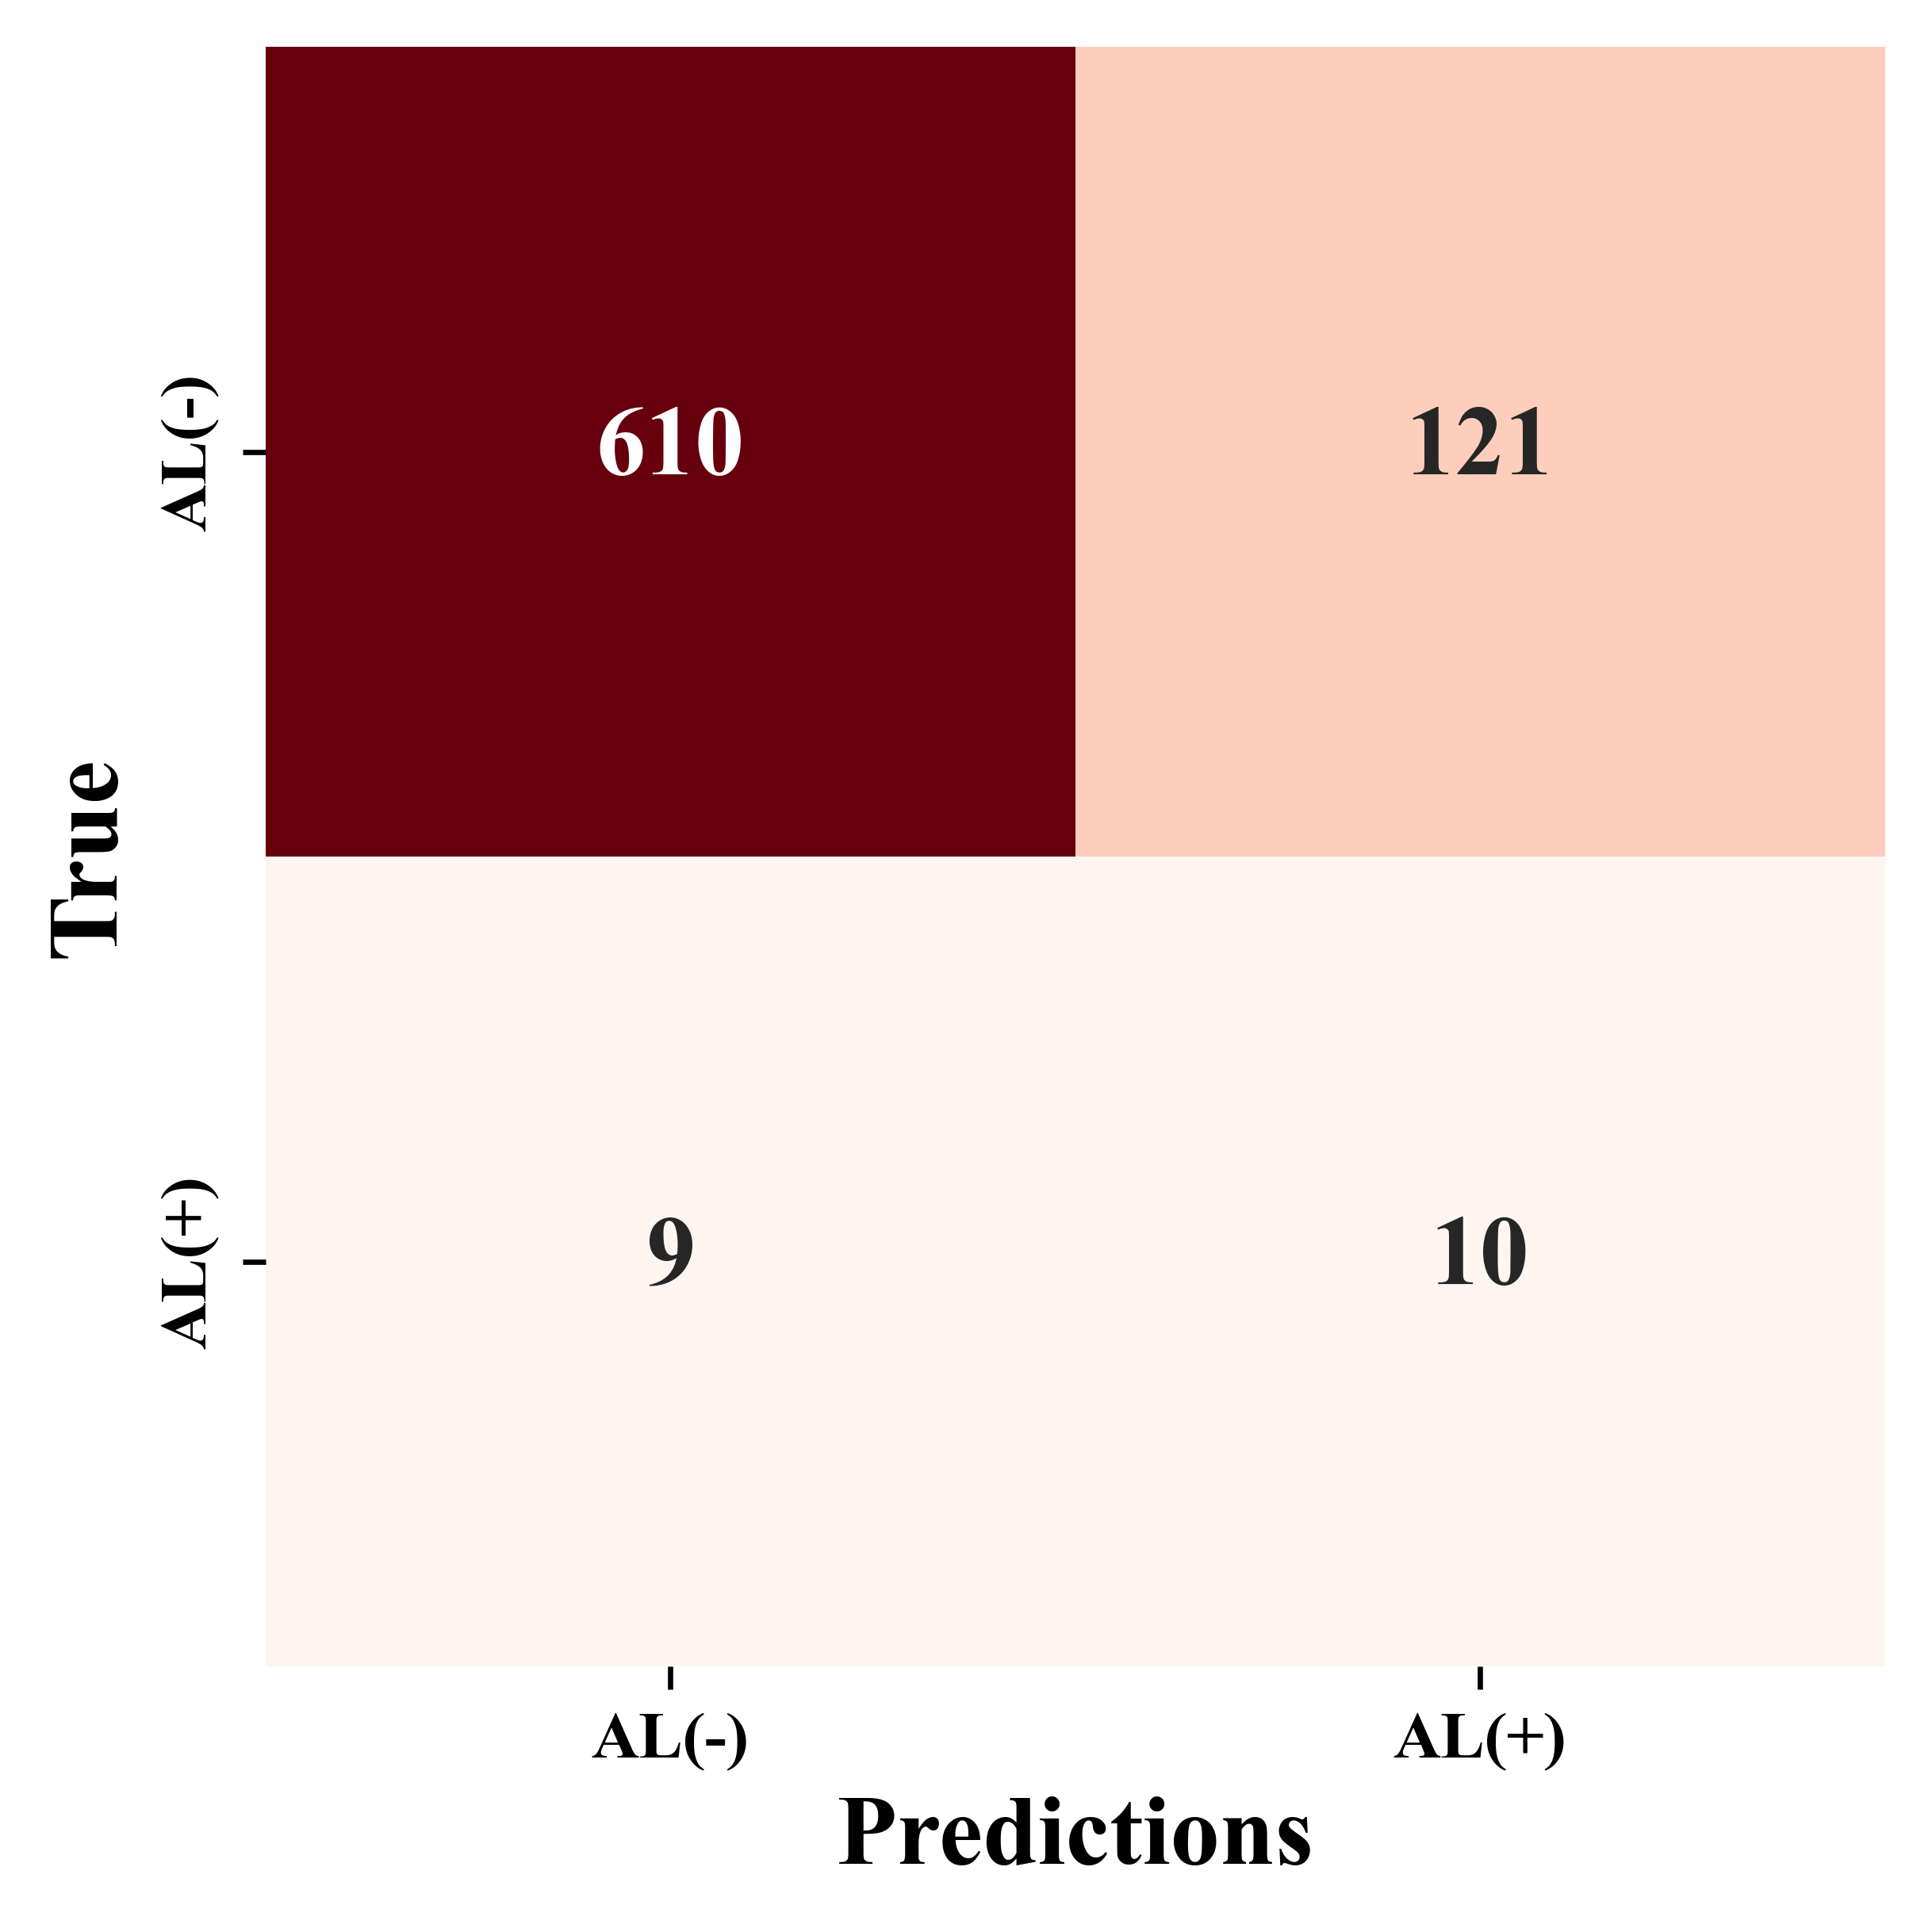

In [9]:
conf_matrix = confusion_matrix(df['al'], df['y_pred1'])
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)
accuracy = accuracy_score(df['al'], df['y_pred1'])
plt.figure(figsize=(4, 4),dpi=600)
sns.heatmap(conf_matrix, 
            annot=True,        
            fmt='d',           
            cmap='Reds', 
            xticklabels=['AL(-)', 'AL(+)'], 
            yticklabels=['AL(-)', 'AL(+)'],
            cbar=False,
           annot_kws={
                'size': 15,      
                'fontfamily': 'Times New Roman', 
                'fontweight': 'bold'   
            })        
plt.xlabel('Predictions',fontproperties = 'Times New Roman',weight='bold', fontsize=15)
plt.ylabel('True', fontproperties = 'Times New Roman',weight='bold',fontsize=15)
plt.xticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.tight_layout(pad=0.5)
#plt.savefig(r"allhunxiao.jpg",dpi=600)
plt.show() 

Sen: 0.5263157894736842 (95%CI: 0.2999-0.7500)
Spe: 0.8344733242134063 (95%CI: 0.8050-0.8626)
PPV: 0.07633587786259542 (95%CI: 0.0354-0.1250)
NPV: 0.9854604200323102 (95%CI: 0.9753-0.9936)
Accu: 0.8266666666666667 (95%CI: 0.7987-0.8547)


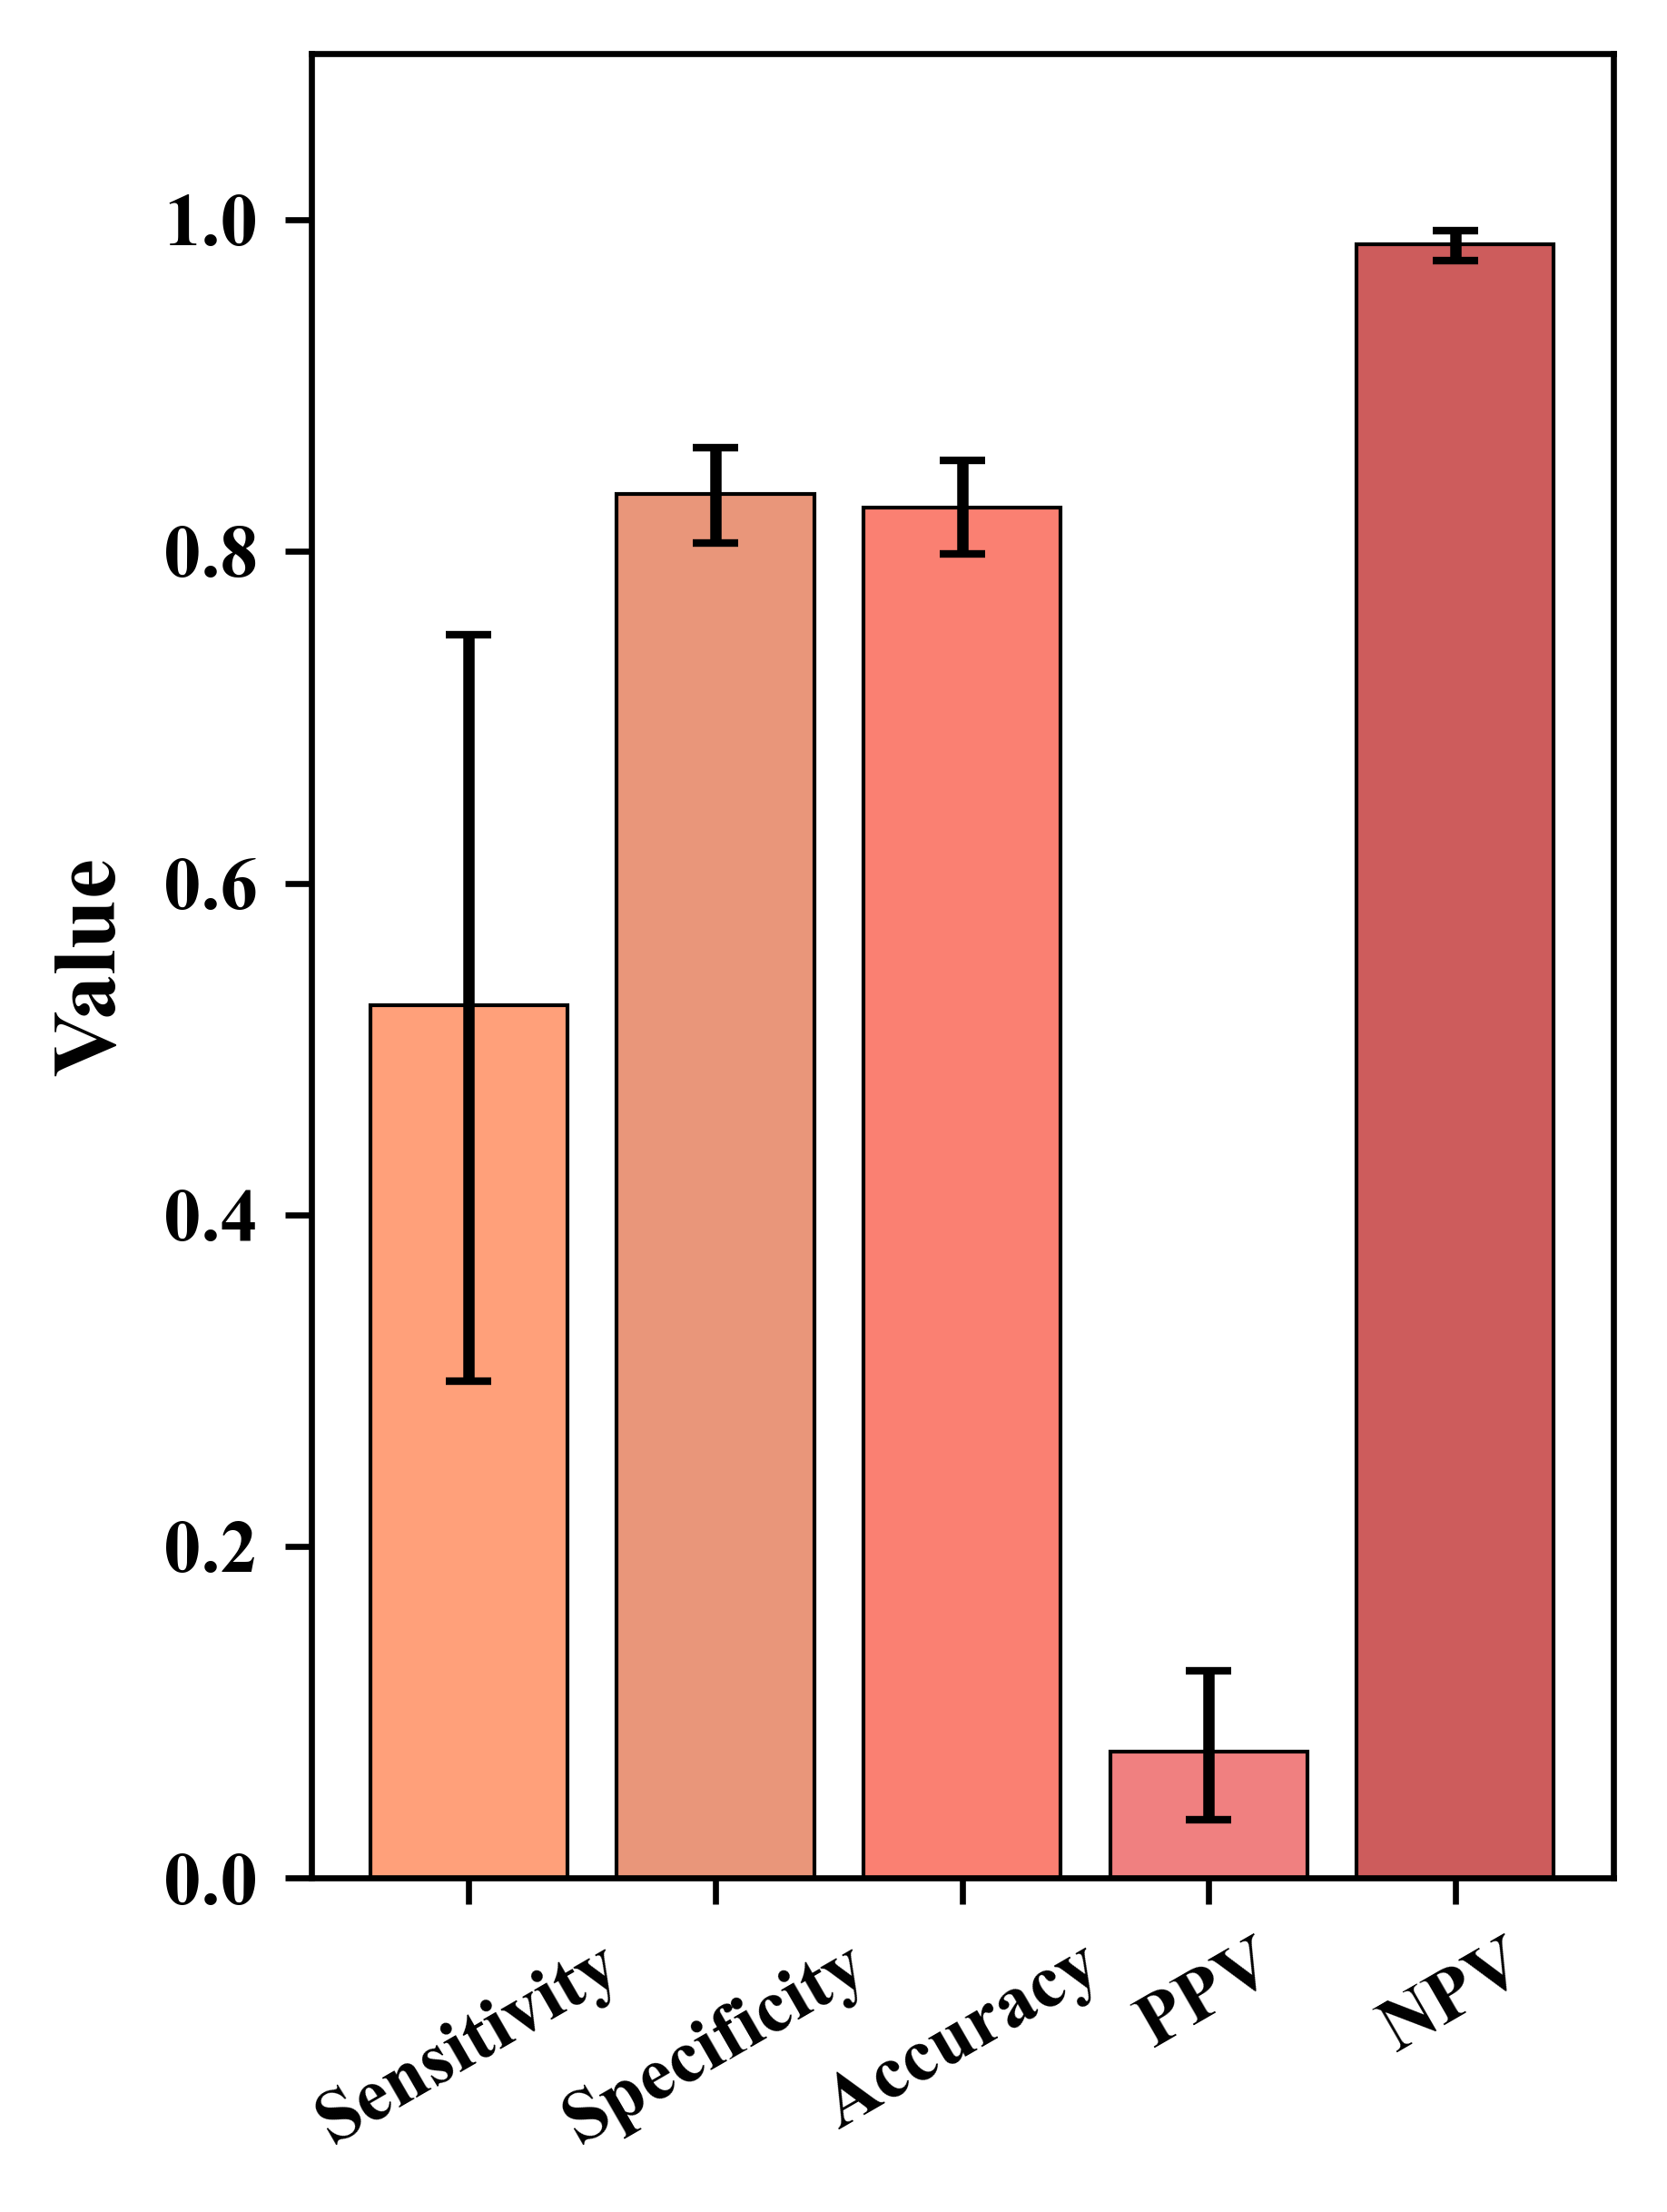

0.5263157894736842 0.8344733242134063 0.07633587786259542 0.9854604200323102 0.8266666666666667


In [13]:
def calculate_95ci_bootstrap(y_true, y_pred, n_iterations=1000):
    sens_list = []
    spec_list = []
    ppv_list = []
    npv_list = []
    acc_list = []
    combined_data = np.column_stack((y_true, y_pred))
    for _ in range(n_iterations):
        boot_sample = resample(combined_data, replace=True, n_samples=len(combined_data))
        boot_y_true = boot_sample[:, 0]
        boot_y_pred = boot_sample[:, 1]
        
        boot_cm = confusion_matrix(boot_y_true, boot_y_pred)
        if boot_cm.shape != (2, 2):  
            continue
        boot_TN = boot_cm[0, 0]
        boot_FP = boot_cm[0, 1]
        boot_FN = boot_cm[1, 0]
        boot_TP = boot_cm[1, 1]
        
        sens = boot_TP / (boot_TP + boot_FN) if (boot_TP + boot_FN) > 0 else 0
        spec = boot_TN / (boot_TN + boot_FP) if (boot_TN + boot_FP) > 0 else 0
        ppv_val = boot_TP / (boot_TP + boot_FP) if (boot_TP + boot_FP) > 0 else 0
        npv_val = boot_TN / (boot_TN + boot_FN) if (boot_TN + boot_FN) > 0 else 0
        acc = accuracy_score(boot_y_true, boot_y_pred)
        
        sens_list.append(sens)
        spec_list.append(spec)
        ppv_list.append(ppv_val)
        npv_list.append(npv_val)
        acc_list.append(acc)

    ci_sensitivity = np.percentile(sens_list, [2.5, 97.5])
    ci_specificity = np.percentile(spec_list, [2.5, 97.5])
    ci_ppv = np.percentile(ppv_list, [2.5, 97.5])
    ci_npv = np.percentile(npv_list, [2.5, 97.5])
    ci_accuracy = np.percentile(acc_list, [2.5, 97.5])
    
    return {
        'sensitivity': ci_sensitivity,
        'specificity': ci_specificity,
        'ppv': ci_ppv,
        'npv': ci_npv,
        'accuracy': ci_accuracy
    }

# 95%CI
ci_results = calculate_95ci_bootstrap(df['al'], df['y_pred1'])
sens_ci = ci_results['sensitivity']
spec_ci = ci_results['specificity']
ppv_ci = ci_results['ppv']
npv_ci = ci_results['npv']
acc_ci = ci_results['accuracy']

print('Sen:', sensitivity, f'(95%CI: {sens_ci[0]:.4f}-{sens_ci[1]:.4f})')
print('Spe:', specificity, f'(95%CI: {spec_ci[0]:.4f}-{spec_ci[1]:.4f})')
print('PPV:', ppv, f'(95%CI: {ppv_ci[0]:.4f}-{ppv_ci[1]:.4f})')
print('NPV:', npv, f'(95%CI: {npv_ci[0]:.4f}-{npv_ci[1]:.4f})')
print('Accu:', accuracy, f'(95%CI: {acc_ci[0]:.4f}-{acc_ci[1]:.4f})')

labels = ['Sensitivity', 'Specificity', 'Accuracy','PPV', 'NPV',]
values = [sensitivity, specificity, accuracy,ppv, npv]

colors=['lightsalmon', 'darksalmon', 'salmon', 'lightcoral', 'indianred']

fig, ax = plt.subplots(figsize=(3, 4), dpi=600)

errors = [
    [values[0] - sens_ci[0], sens_ci[1] - values[0]],  
    [values[1] - spec_ci[0], spec_ci[1] - values[1]],  
    [values[2] - acc_ci[0], acc_ci[1] - values[2]],    
    [values[3] - ppv_ci[0], ppv_ci[1] - values[3]],    
    [values[4] - npv_ci[0], npv_ci[1] - values[4]]     
]

yerr = np.array(errors).T

bars = ax.bar(labels, values, color=colors, yerr=yerr, capsize=3, edgecolor='black', linewidth=0.5)


ax.set_ylabel('Value',fontproperties = 'Times New Roman',weight='bold',fontsize=12)
plt.xticks(rotation=30,fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.ylim(0,1.1)

ci_pairs = [sens_ci, spec_ci, acc_ci, ppv_ci, npv_ci]  

plt.tight_layout(pad=0.5)
#plt.savefig(r"allpara.jpg",dpi=600)
plt.show()

Figure 3c

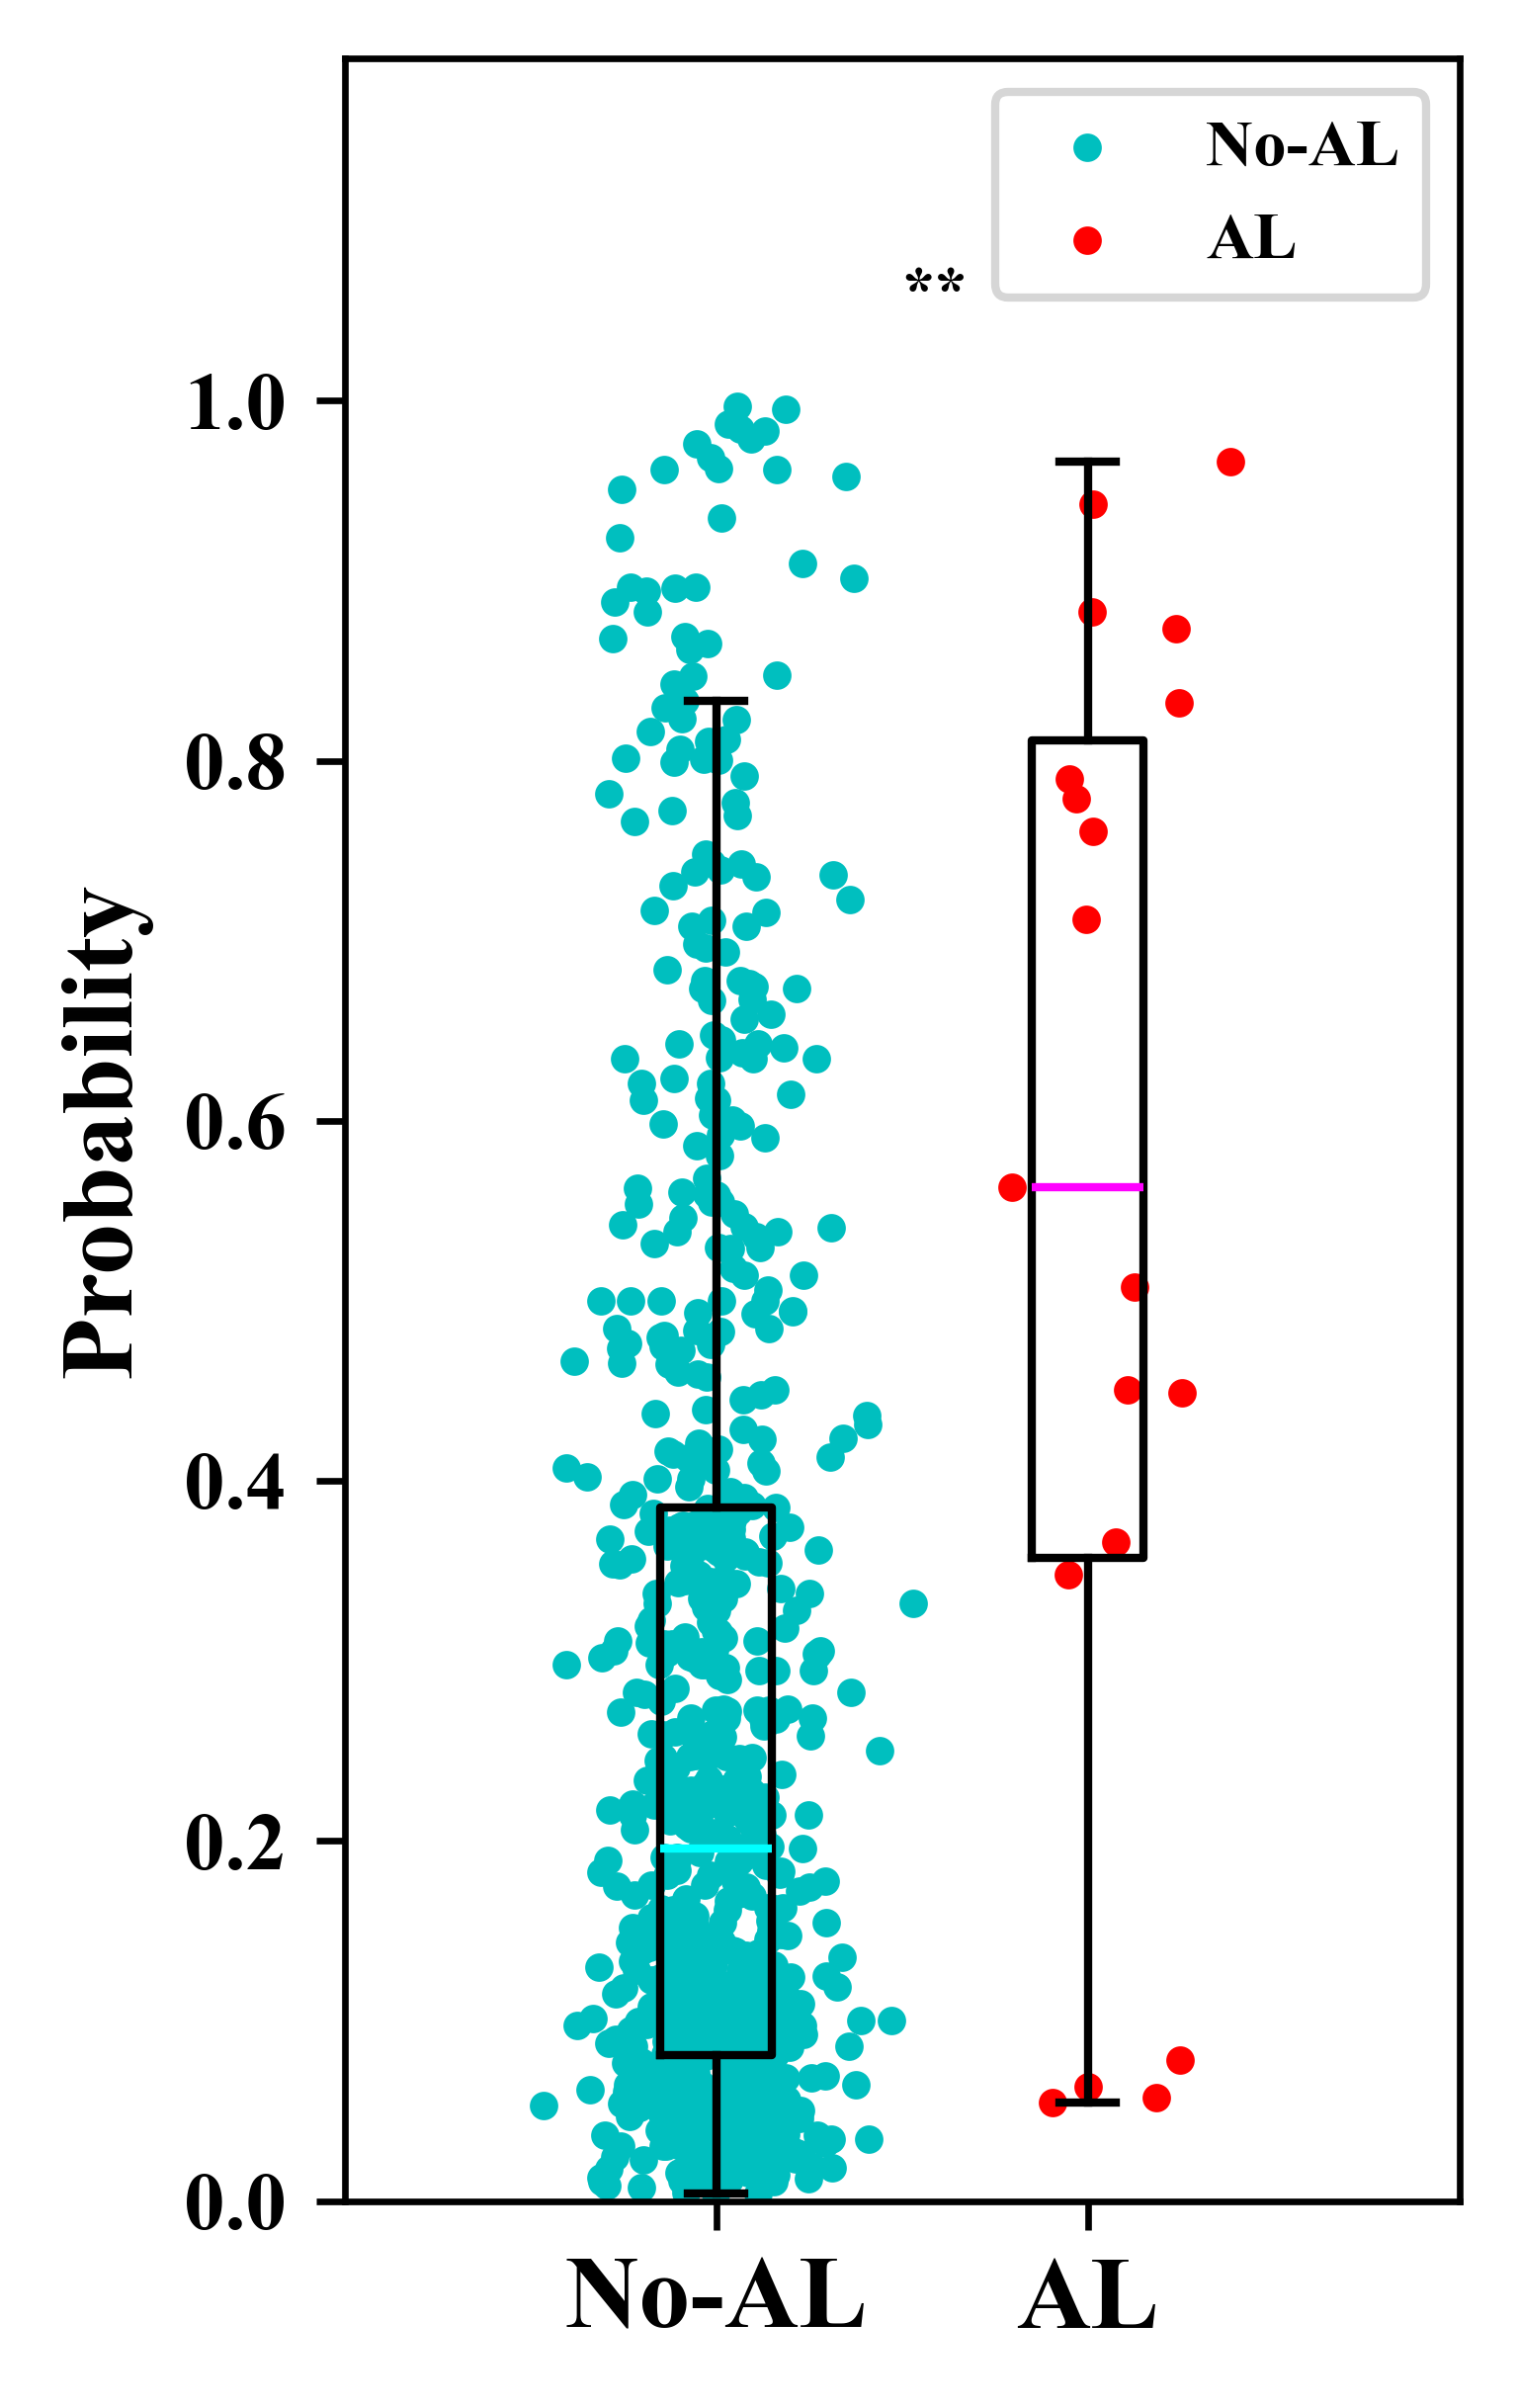

In [18]:
data1 = [df['pres_proba'][df['al'] == 0], df['pres_proba'][df['al'] == 1]]
positions = []
gap_between_pairs = 0.5 
for i in range(2):
    base_pos = i * gap_between_pairs + 1
    positions.append(base_pos)
plt.figure(figsize=(2.5, 4), dpi=600)
bp = plt.boxplot(data1, positions=positions, showfliers=False)
for patch in bp['boxes']:
    patch.set_color('black')
new_positions = positions
custom_labels = ['No-AL', 'AL']
plt.xticks(new_positions, custom_labels)
median_colors = ['cyan', 'magenta']
for i, median in enumerate(bp['medians']):
    median.set_color(median_colors[i % 2])
scatter_colors = ['c', 'red']
for i, d in enumerate(data1):
    x = np.random.normal(positions[i], 0.075, size=len(d))
    label = 'No-AL' if scatter_colors[i] == 'c' else 'AL'
    plt.scatter(x, d, color=scatter_colors[i], alpha=1, s=6, label=label if i < 2 else "")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # 去重
fontdict_prop = {'family': 'Times New Roman',
                 'weight': 'bold',
                 'size': 8,
                 }
plt.legend(by_label.values(), by_label.keys(),loc='upper right', prop=fontdict_prop)

plt.ylabel('Probability', fontproperties='Times New Roman', fontsize=12.5, weight='bold')
plt.xticks(rotation=0,  fontproperties='Times New Roman',fontsize=12.5, weight='bold')
plt.yticks(rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')

plt.ylim(0, 1.19)
plt.text(1.25,1.05, '**',rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')
plt.tight_layout(pad=0.5)
#plt.savefig(r"allproba.jpg",dpi=600)
plt.show()

Figure 3d

In [21]:
excel_file = pd.ExcelFile(r'control.xlsx')
sheet_names = excel_file.sheet_names
sheet_names
df = excel_file.parse('Sheet1')

<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
C:\Users\SSL\AppData\Local\Temp\ipykernel_6152\1389719646.py:35: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, color='olive', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))


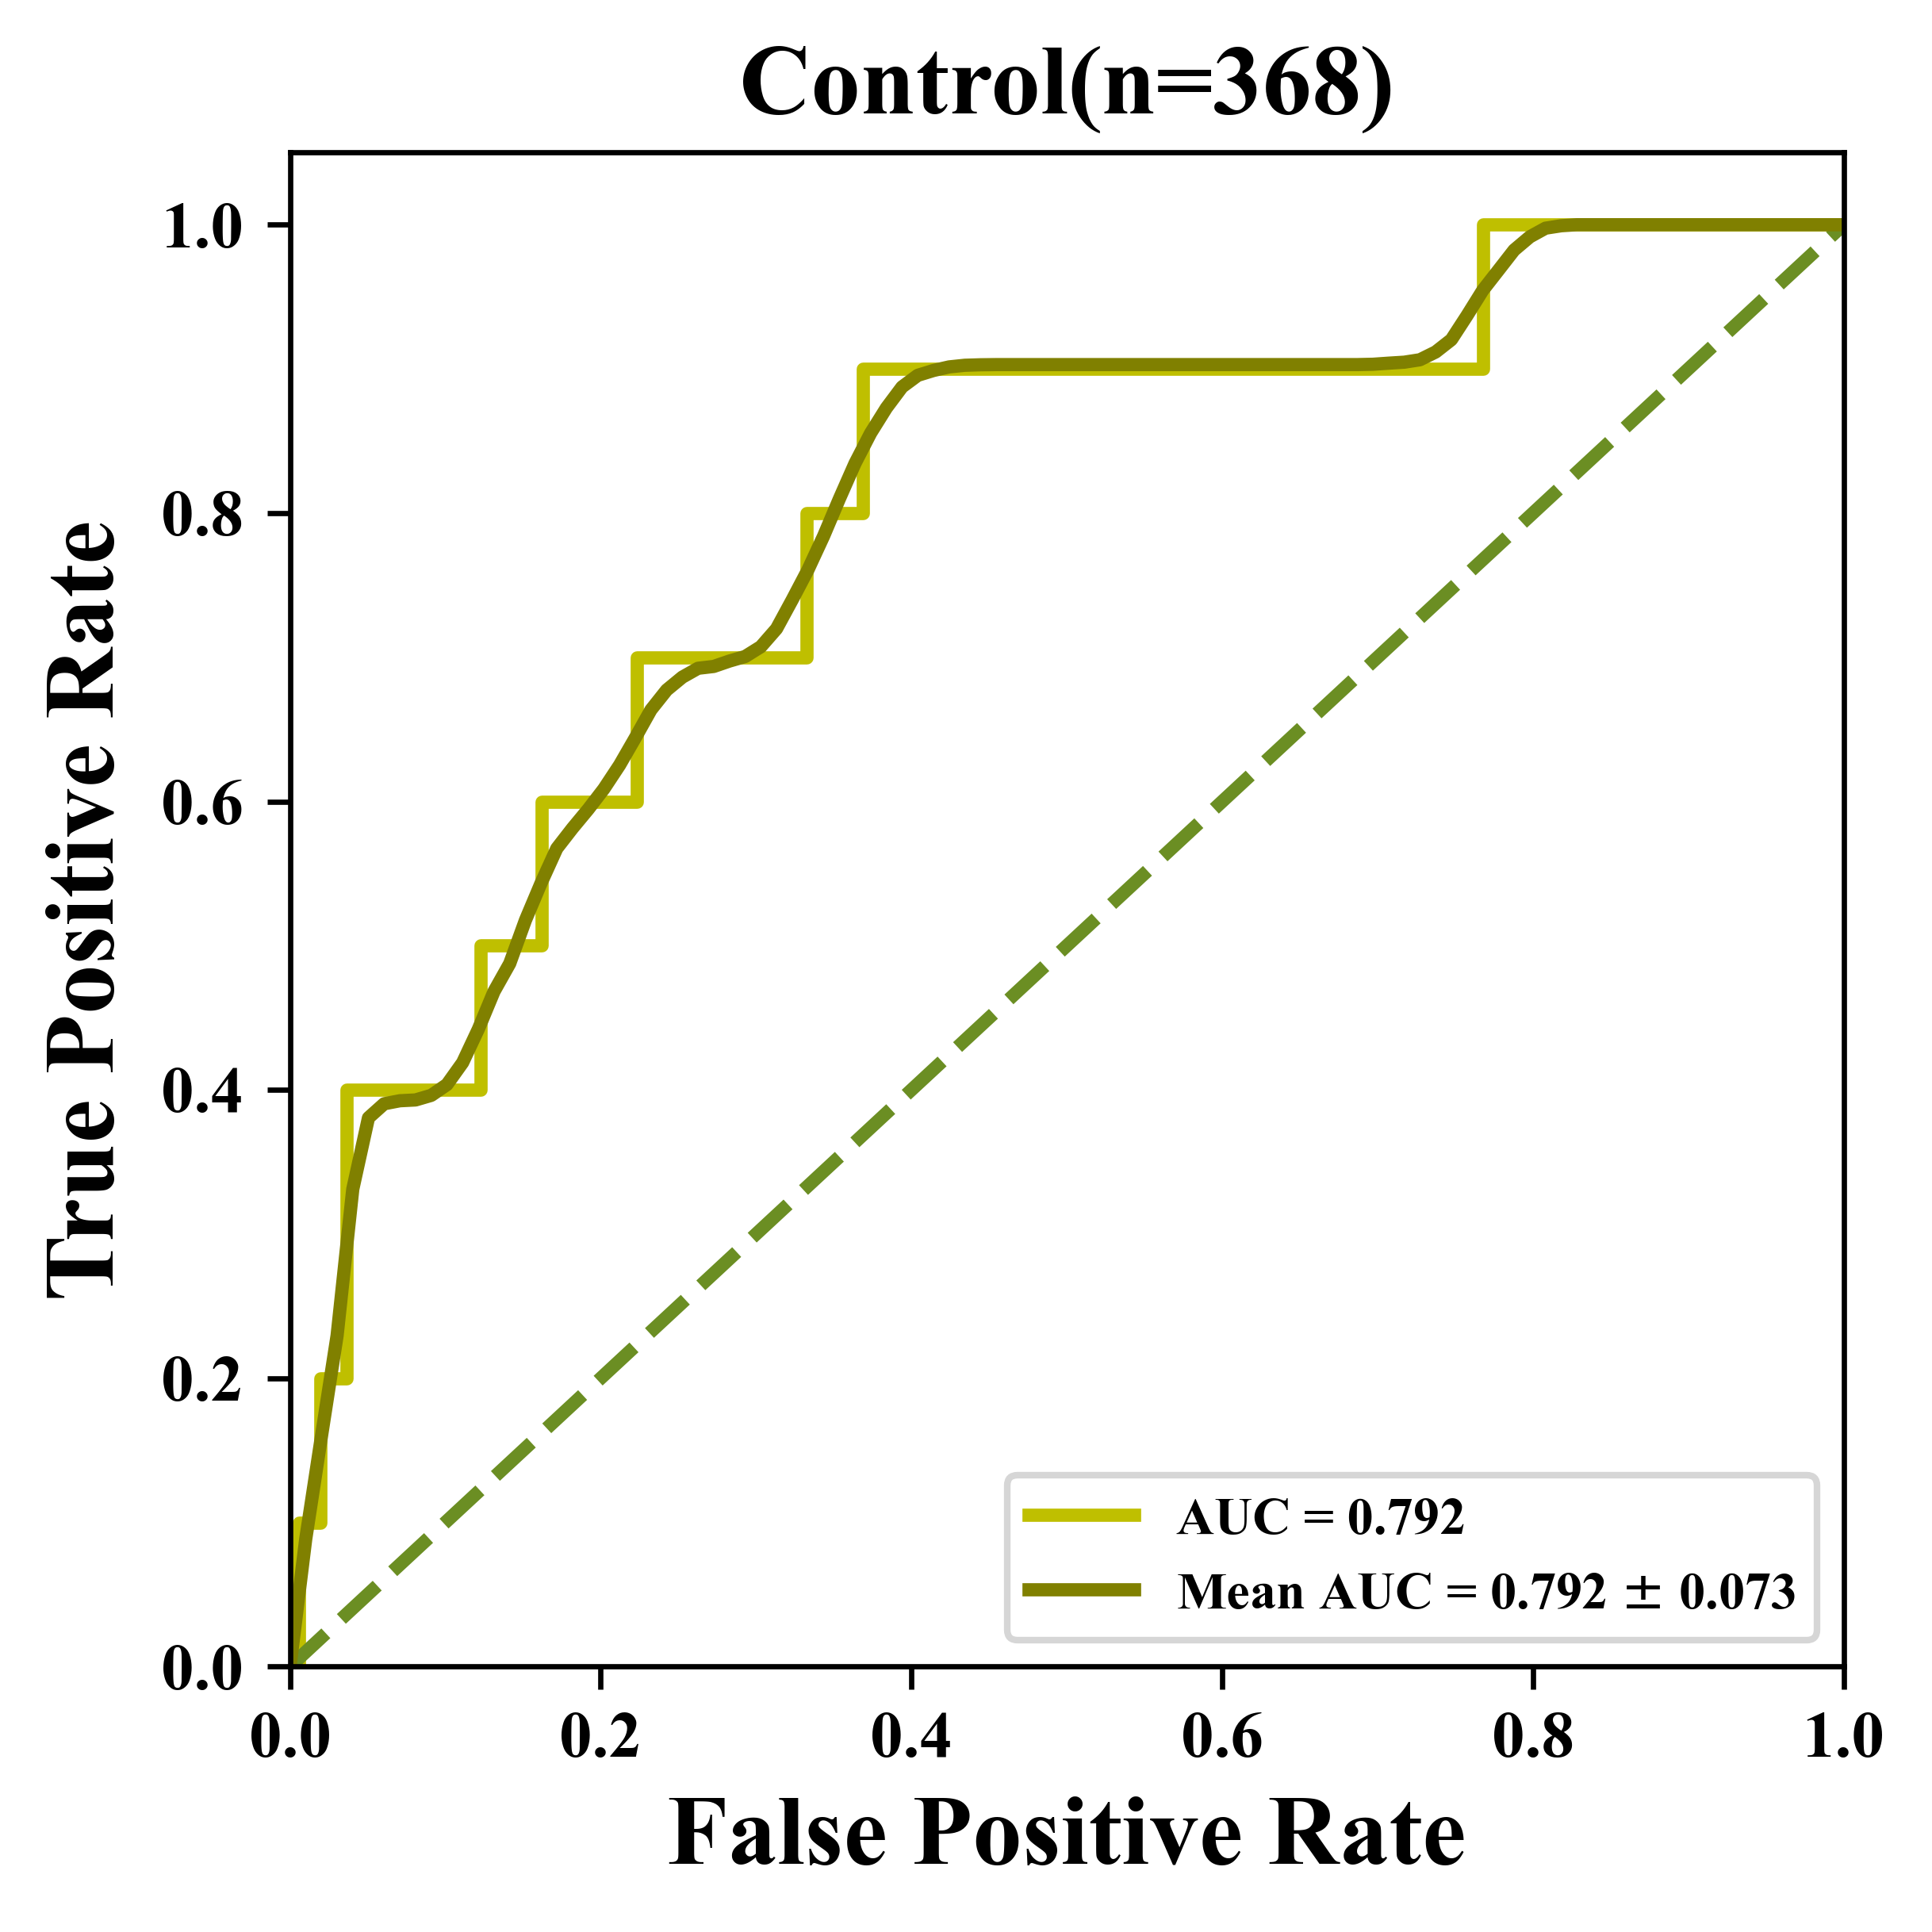

In [23]:
np.random.seed(2025)
plt.figure(figsize=(4, 4),dpi=600)
fpr, tpr, _ = roc_curve(df['al'], df['pres_proba'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='y', lw=2, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='olivedrab', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.ylabel('True Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.xticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.yticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.title('Control(n=368)',fontproperties = 'Times New Roman',fontsize = 15,weight='bold')
plt.legend(loc='lower right')
n_bootstraps = 1000
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i in range(n_bootstraps):
    indices = resample(np.arange(len(df['al'])))
    fpr_bs, tpr_bs, _ = roc_curve(df['al'].iloc[indices], df['pres_proba'].iloc[indices])
    roc_auc_bs = auc(fpr_bs, tpr_bs)
    interp_tpr = np.interp(mean_fpr, fpr_bs, tpr_bs)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc_bs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
lower_bound = np.percentile(aucs, 2.5)
upper_bound = np.percentile(aucs, 97.5)
plt.plot(mean_fpr, mean_tpr, color='olive', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))
fontdict_prop = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 8,
}
plt.legend(loc="lower right",prop=fontdict_prop)
plt.tight_layout(pad=0.5)
#plt.savefig(r"controlroc.jpg",dpi=600)
plt.show() 

Figure 3e

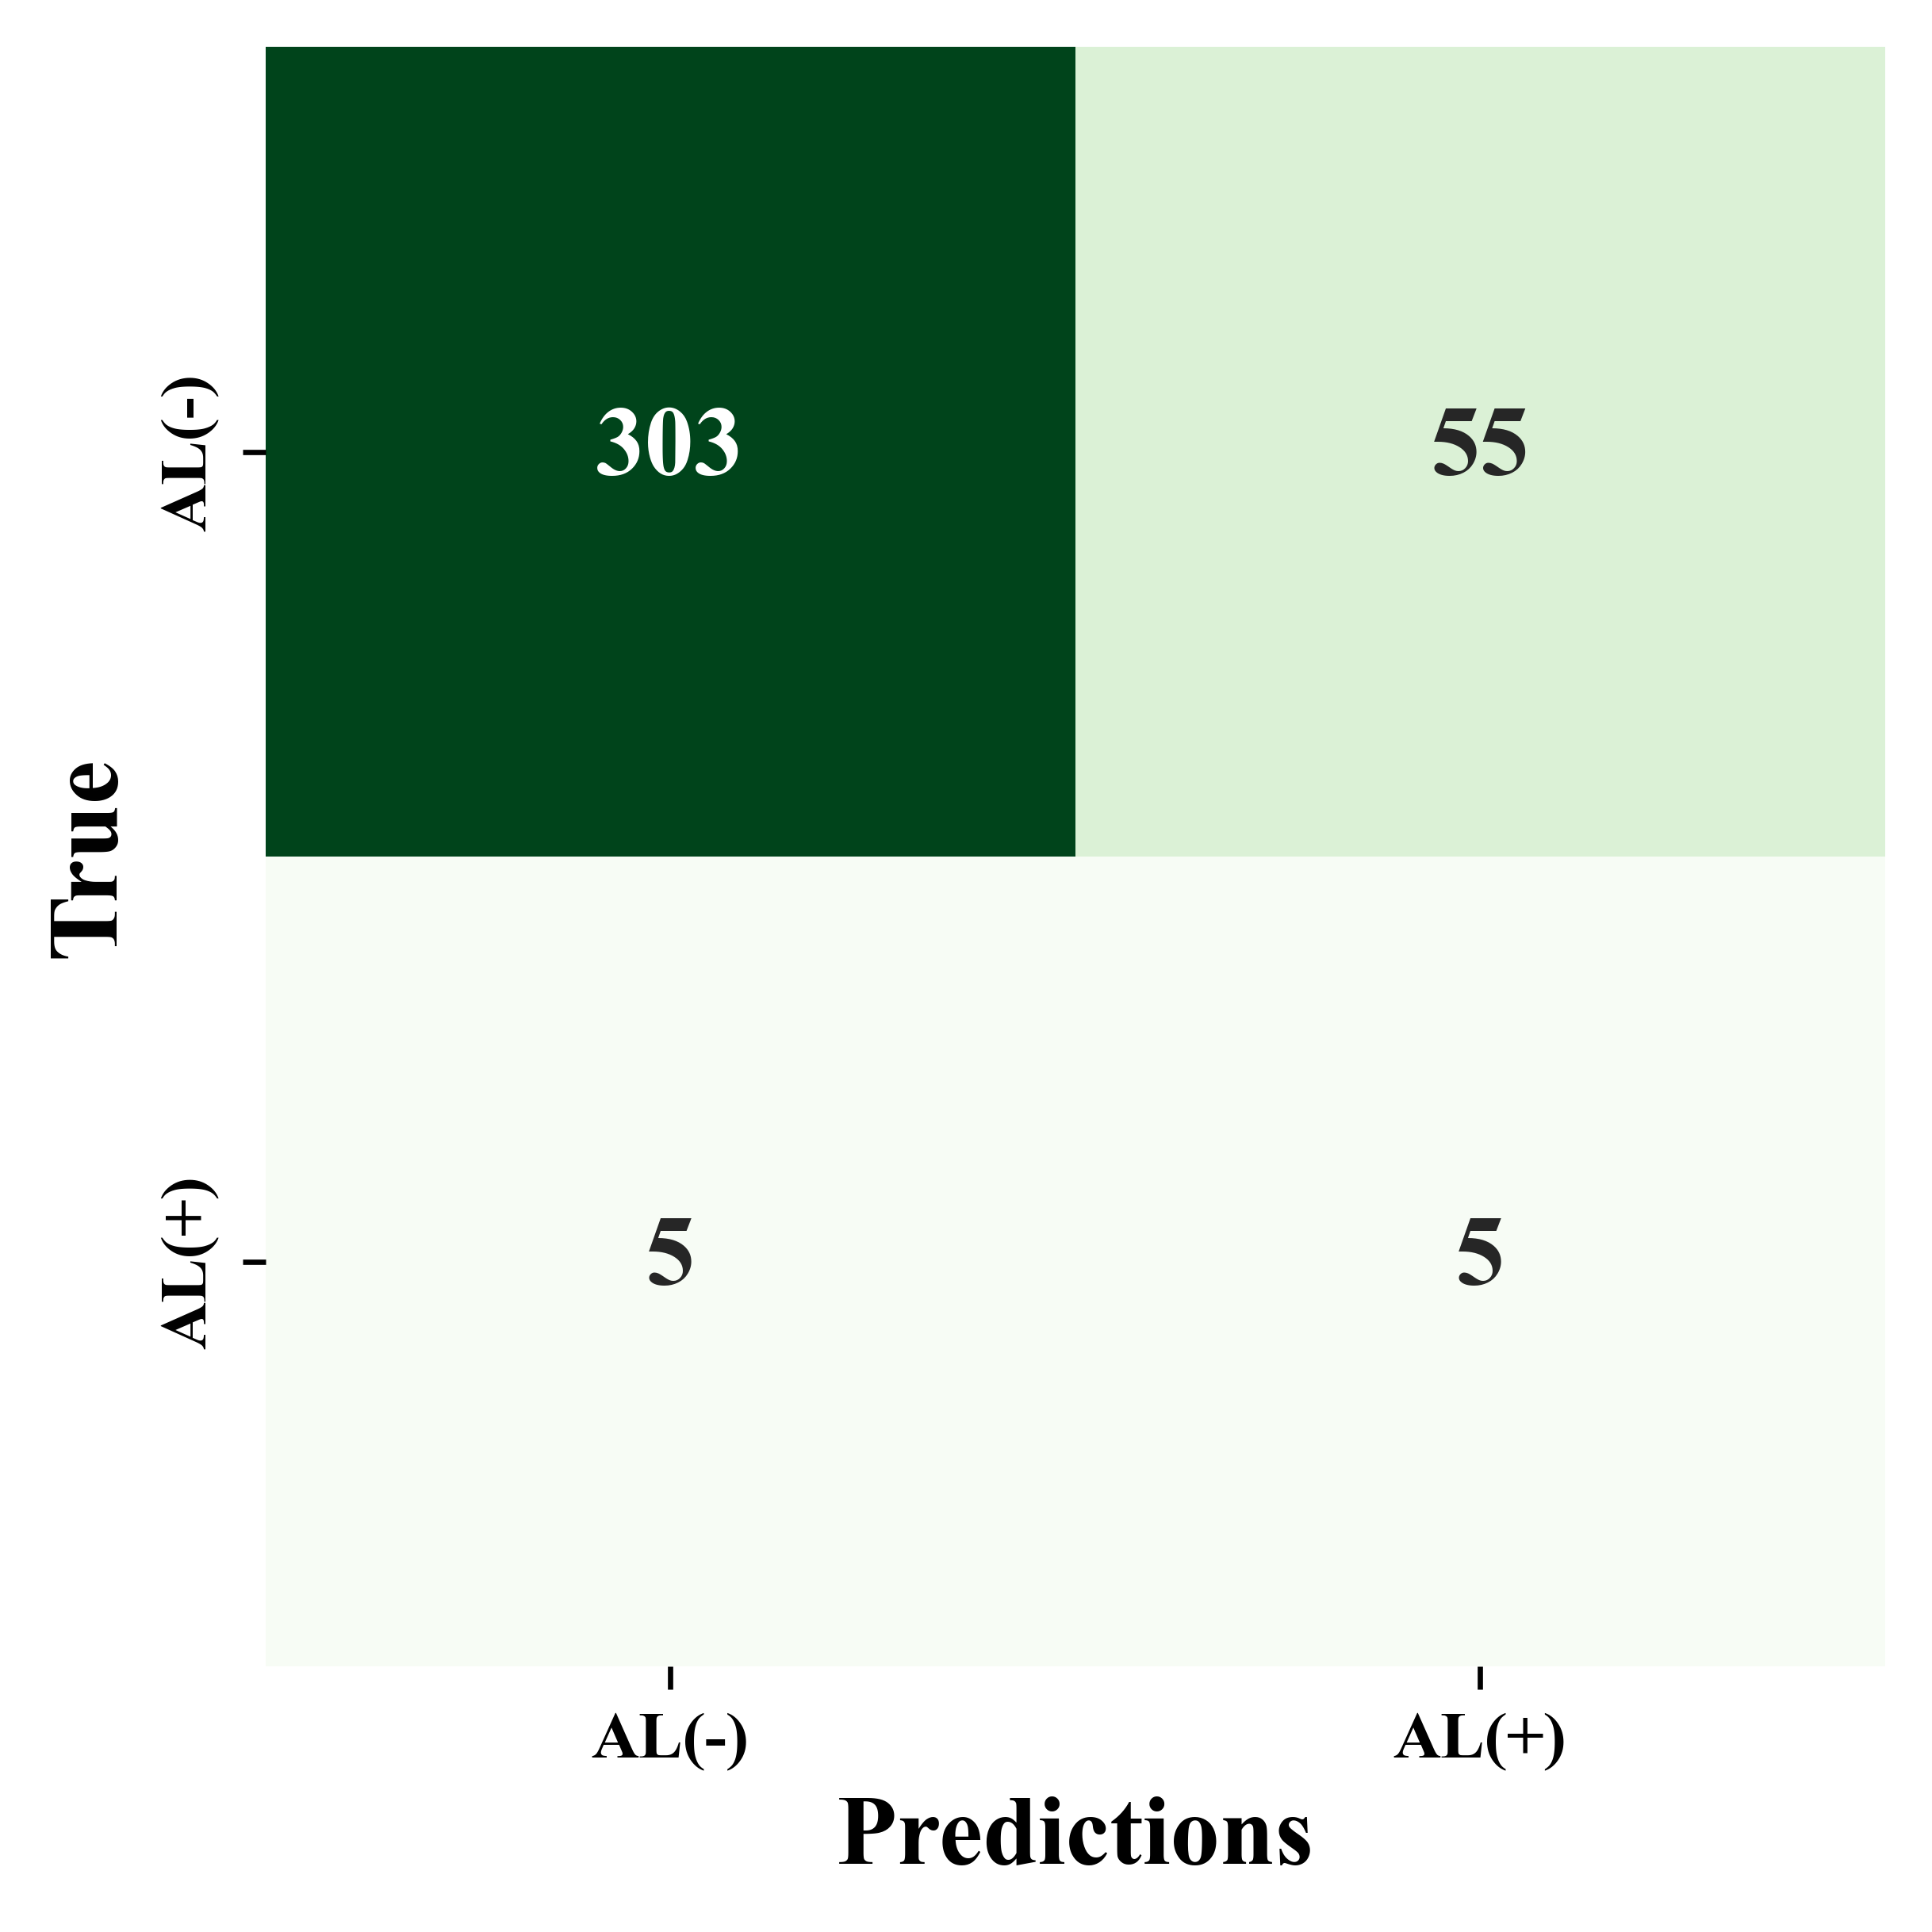

In [26]:
conf_matrix = confusion_matrix(df['al'], df['y_pred1'])
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)
accuracy = accuracy_score(df['al'], df['y_pred1'])
plt.figure(figsize=(4, 4),dpi=600)
sns.heatmap(conf_matrix, 
            annot=True,        
            fmt='d',           
            cmap='Greens', 
            xticklabels=['AL(-)', 'AL(+)'],  
            yticklabels=['AL(-)', 'AL(+)'],
            cbar=False,
           annot_kws={
                'size': 15,      
                'fontfamily': 'Times New Roman',  
                'fontweight': 'bold'  
            })        

plt.xlabel('Predictions',fontproperties = 'Times New Roman',weight='bold', fontsize=15)
plt.ylabel('True', fontproperties = 'Times New Roman',weight='bold',fontsize=15)
plt.xticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.tight_layout(pad=0.5)
#plt.savefig(r"controlhunxiao.jpg",dpi=600)
plt.show() 

Sen: 0.5 (95%CI: 0.1667-0.8333)
Spe: 0.8463687150837989 (95%CI: 0.8090-0.8833)
PPV: 0.08333333333333333 (95%CI: 0.0175-0.1552)
NPV: 0.9837662337662337 (95%CI: 0.9684-0.9967)
Accu: 0.8369565217391305 (95%CI: 0.7989-0.8750)


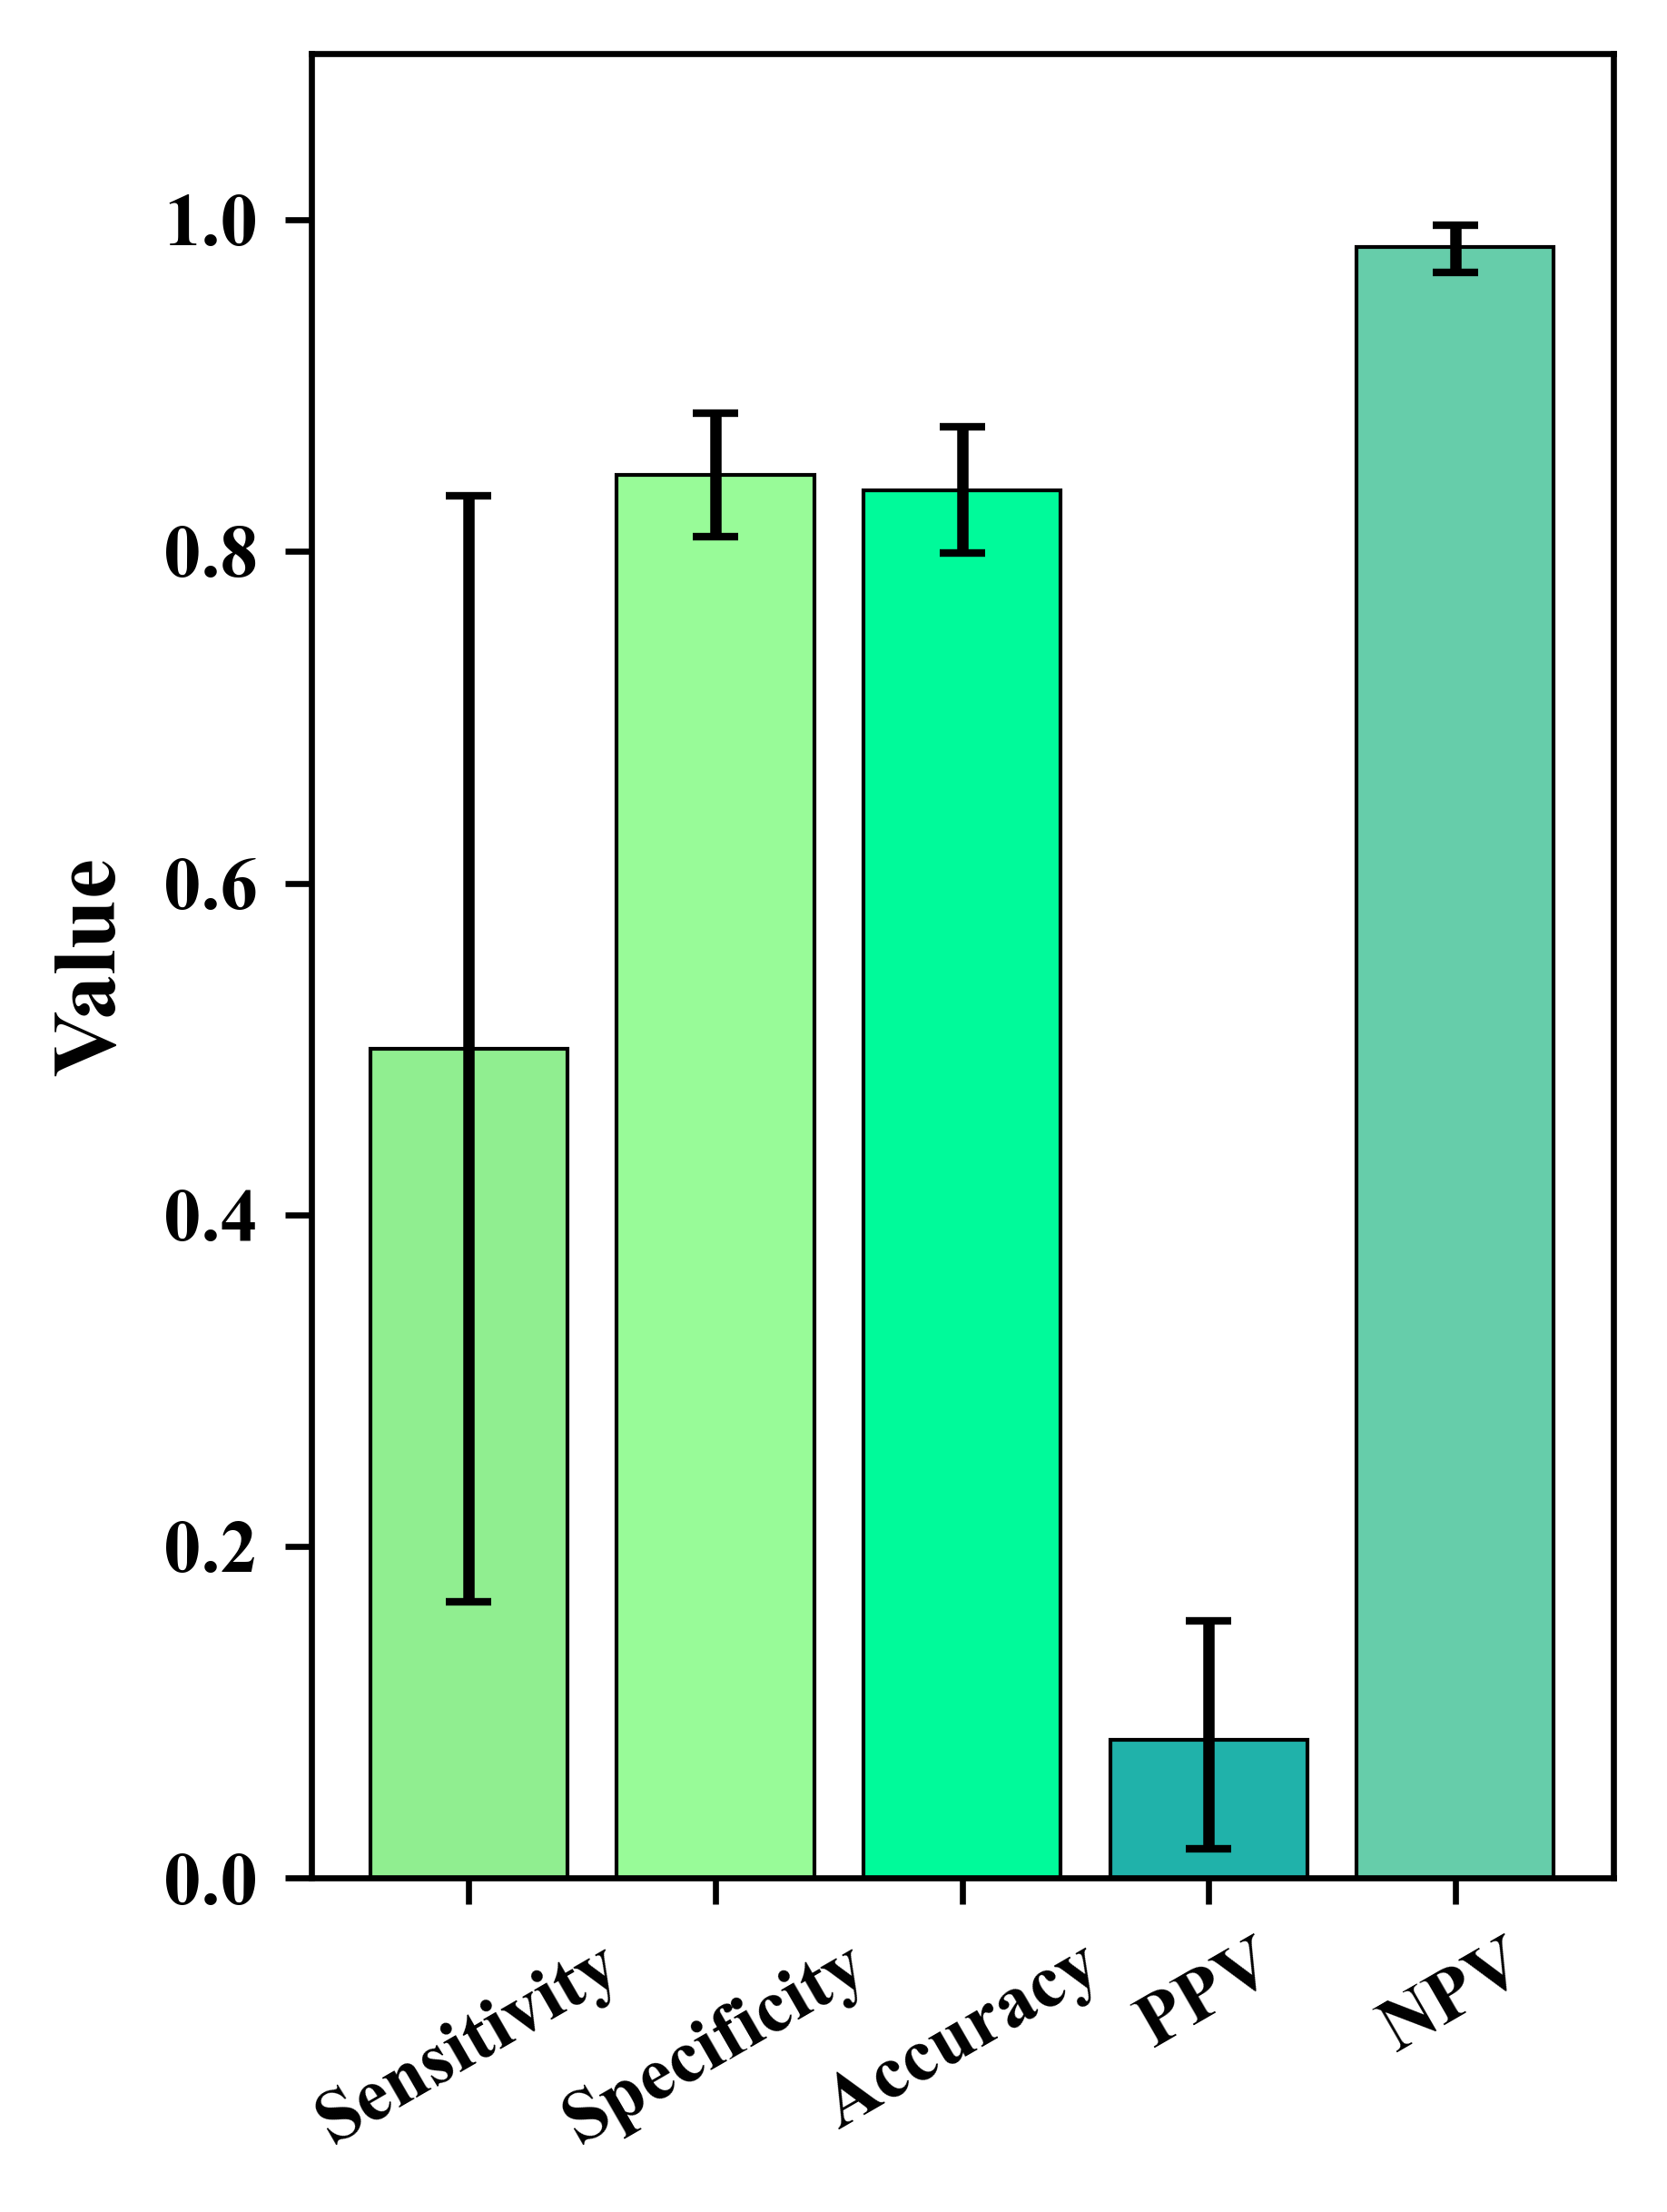

0.5 0.8463687150837989 0.08333333333333333 0.9837662337662337 0.8369565217391305


In [30]:
def calculate_95ci_bootstrap(y_true, y_pred, n_iterations=1000):
    sens_list = []
    spec_list = []
    ppv_list = []
    npv_list = []
    acc_list = []
    combined_data = np.column_stack((y_true, y_pred))
    for _ in range(n_iterations):
        boot_sample = resample(combined_data, replace=True, n_samples=len(combined_data))
        boot_y_true = boot_sample[:, 0]
        boot_y_pred = boot_sample[:, 1]
        
        boot_cm = confusion_matrix(boot_y_true, boot_y_pred)
        if boot_cm.shape != (2, 2):  
            continue
        boot_TN = boot_cm[0, 0]
        boot_FP = boot_cm[0, 1]
        boot_FN = boot_cm[1, 0]
        boot_TP = boot_cm[1, 1]
        
        sens = boot_TP / (boot_TP + boot_FN) if (boot_TP + boot_FN) > 0 else 0
        spec = boot_TN / (boot_TN + boot_FP) if (boot_TN + boot_FP) > 0 else 0
        ppv_val = boot_TP / (boot_TP + boot_FP) if (boot_TP + boot_FP) > 0 else 0
        npv_val = boot_TN / (boot_TN + boot_FN) if (boot_TN + boot_FN) > 0 else 0
        acc = accuracy_score(boot_y_true, boot_y_pred)
        
        sens_list.append(sens)
        spec_list.append(spec)
        ppv_list.append(ppv_val)
        npv_list.append(npv_val)
        acc_list.append(acc)

    ci_sensitivity = np.percentile(sens_list, [2.5, 97.5])
    ci_specificity = np.percentile(spec_list, [2.5, 97.5])
    ci_ppv = np.percentile(ppv_list, [2.5, 97.5])
    ci_npv = np.percentile(npv_list, [2.5, 97.5])
    ci_accuracy = np.percentile(acc_list, [2.5, 97.5])
    
    return {
        'sensitivity': ci_sensitivity,
        'specificity': ci_specificity,
        'ppv': ci_ppv,
        'npv': ci_npv,
        'accuracy': ci_accuracy
    }

# 95%CI
ci_results = calculate_95ci_bootstrap(df['al'], df['y_pred1'])
sens_ci = ci_results['sensitivity']
spec_ci = ci_results['specificity']
ppv_ci = ci_results['ppv']
npv_ci = ci_results['npv']
acc_ci = ci_results['accuracy']

print('Sen:', sensitivity, f'(95%CI: {sens_ci[0]:.4f}-{sens_ci[1]:.4f})')
print('Spe:', specificity, f'(95%CI: {spec_ci[0]:.4f}-{spec_ci[1]:.4f})')
print('PPV:', ppv, f'(95%CI: {ppv_ci[0]:.4f}-{ppv_ci[1]:.4f})')
print('NPV:', npv, f'(95%CI: {npv_ci[0]:.4f}-{npv_ci[1]:.4f})')
print('Accu:', accuracy, f'(95%CI: {acc_ci[0]:.4f}-{acc_ci[1]:.4f})')

labels = ['Sensitivity', 'Specificity', 'Accuracy','PPV', 'NPV',]
values = [sensitivity, specificity, accuracy,ppv, npv]

colors = ['lightgreen', 'palegreen', 'mediumspringgreen', 'lightseagreen', 'mediumaquamarine']

fig, ax = plt.subplots(figsize=(3, 4), dpi=600)

errors = [
    [values[0] - sens_ci[0], sens_ci[1] - values[0]],  
    [values[1] - spec_ci[0], spec_ci[1] - values[1]],  
    [values[2] - acc_ci[0], acc_ci[1] - values[2]],    
    [values[3] - ppv_ci[0], ppv_ci[1] - values[3]],    
    [values[4] - npv_ci[0], npv_ci[1] - values[4]]     
]

yerr = np.array(errors).T

bars = ax.bar(labels, values, color=colors, yerr=yerr, capsize=3, edgecolor='black', linewidth=0.5)


ax.set_ylabel('Value',fontproperties = 'Times New Roman',weight='bold',fontsize=12)
plt.xticks(rotation=30,fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.ylim(0,1.1)

ci_pairs = [sens_ci, spec_ci, acc_ci, ppv_ci, npv_ci]  

plt.tight_layout(pad=0.5)
#plt.savefig(r"controlpara.jpg",dpi=600)
plt.show()

Figure 3f

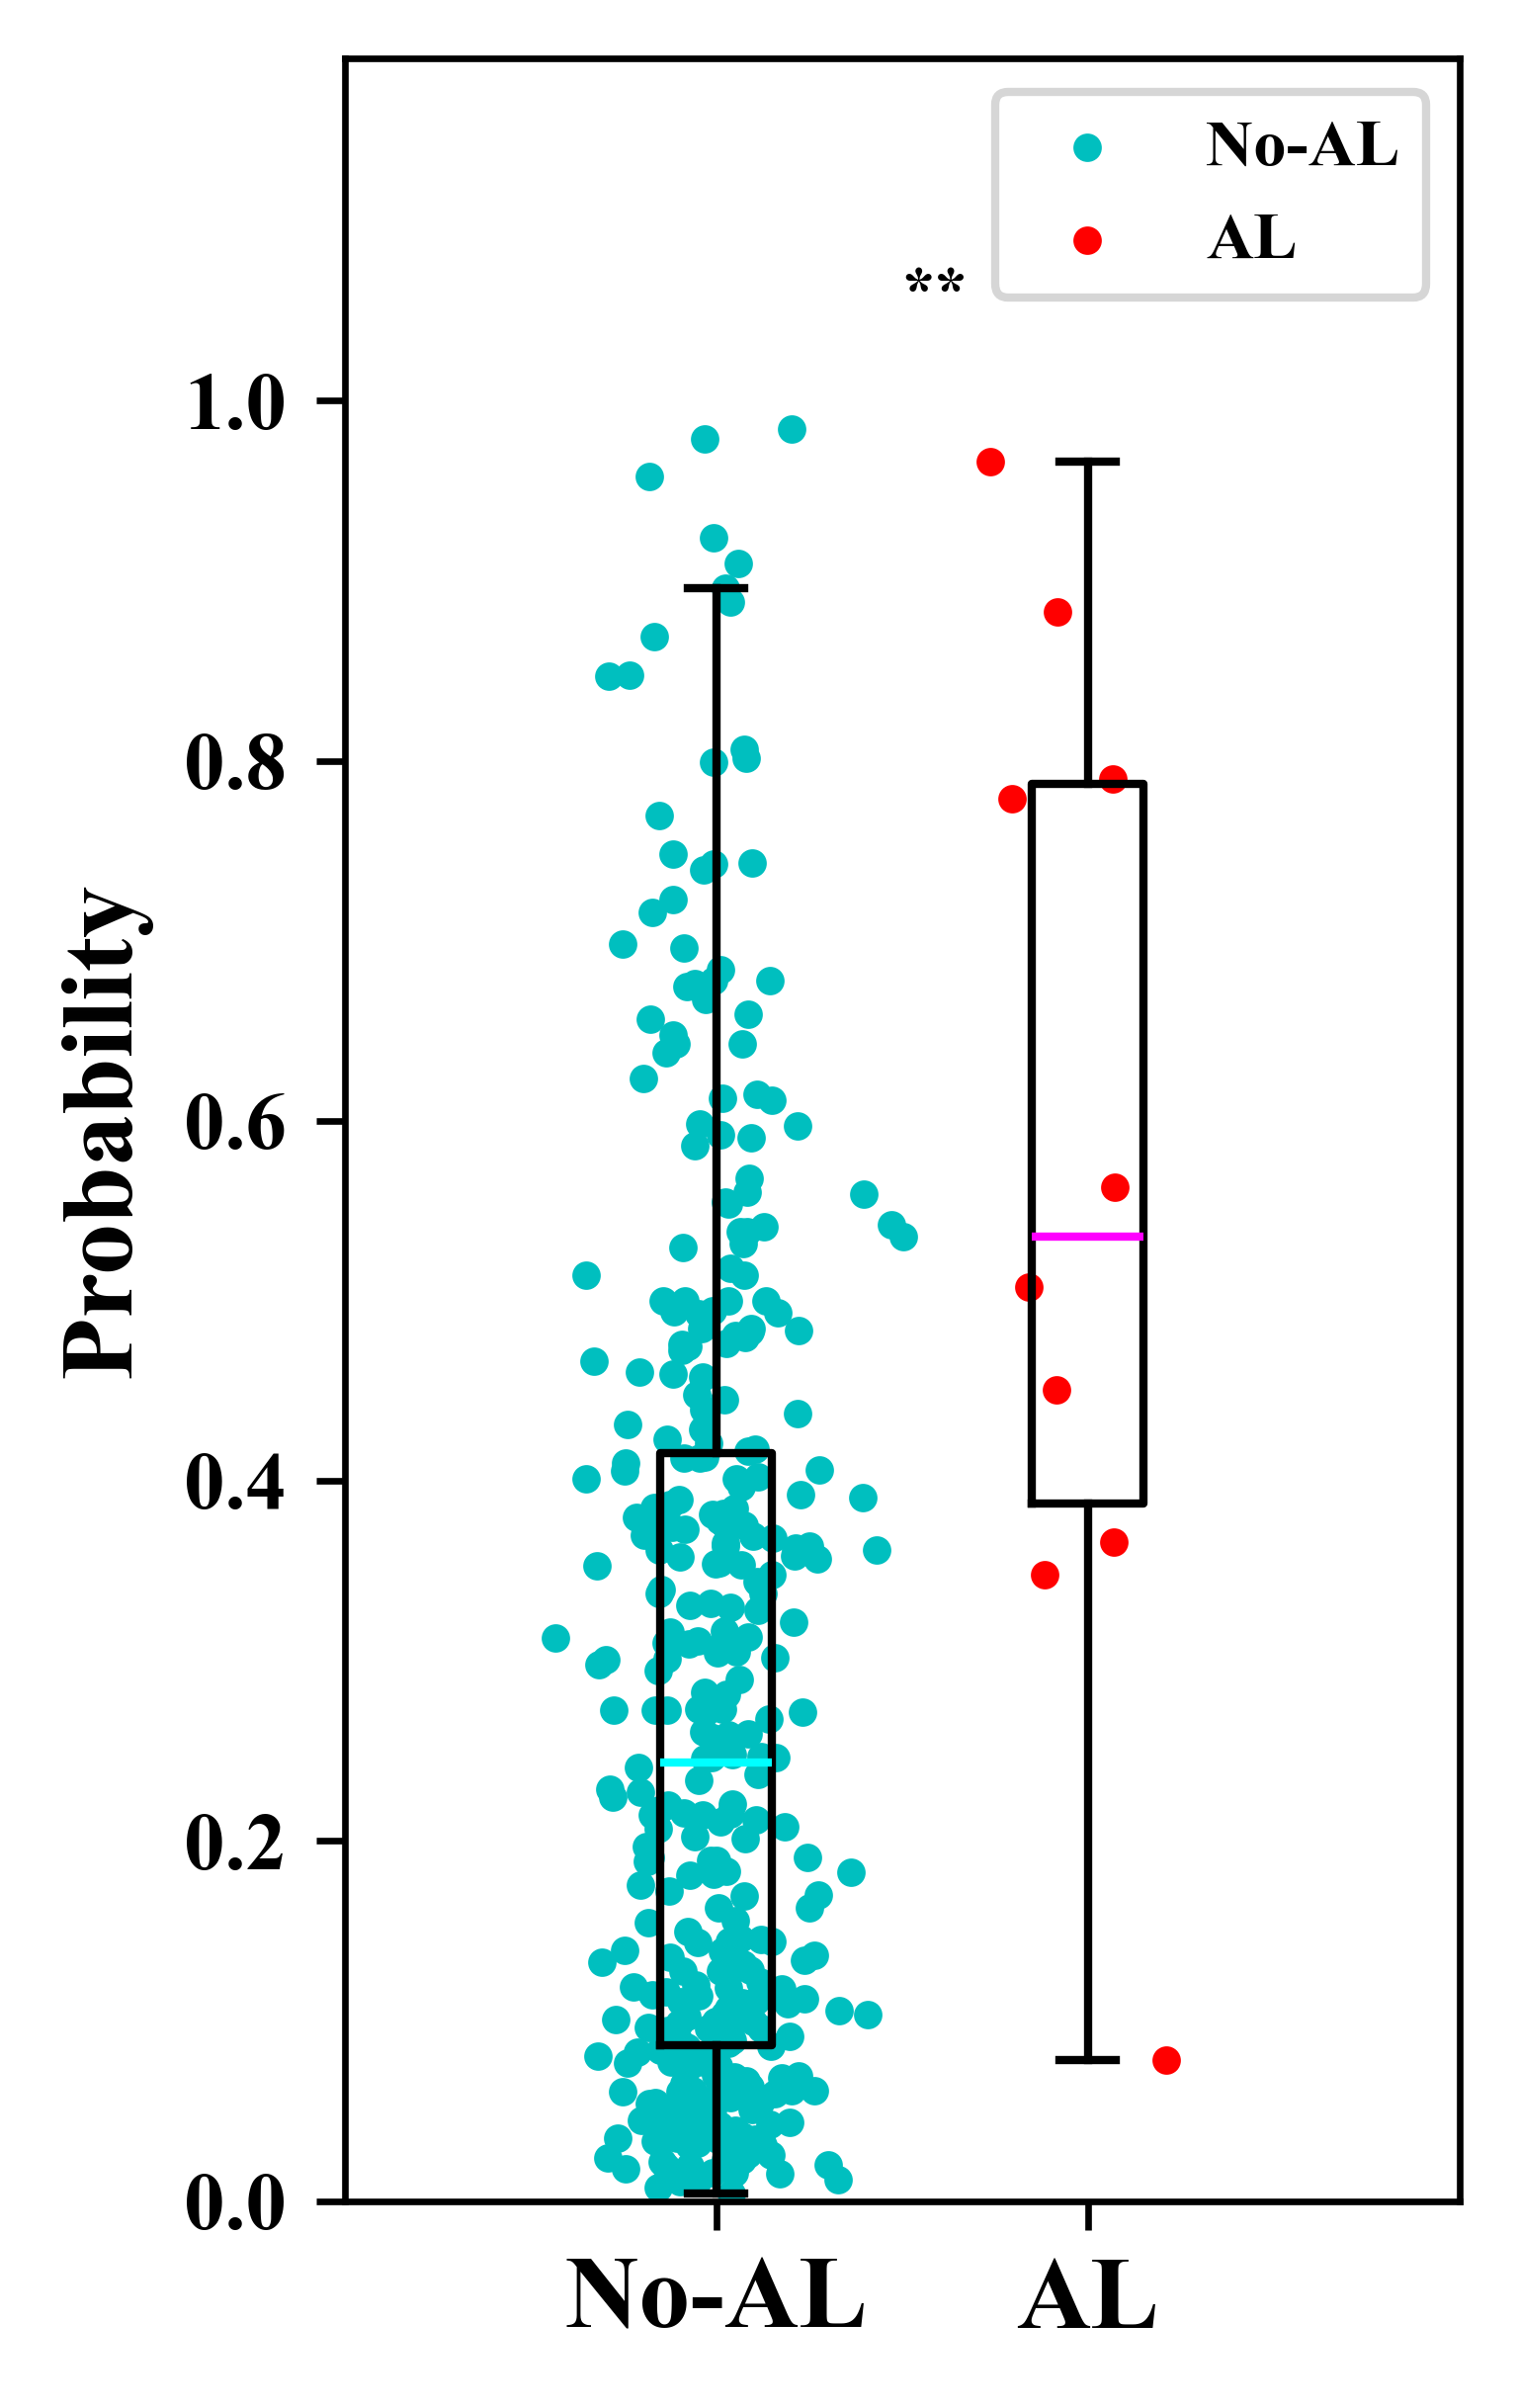

In [35]:
df = pd.read_excel(r'control.xlsx')
data1 = [df['pres_proba'][df['al'] == 0], df['pres_proba'][df['al'] == 1]]
positions = []
gap_between_pairs = 0.5  
for i in range(2):
    base_pos = i * gap_between_pairs + 1
    positions.append(base_pos)
plt.figure(figsize=(2.5, 4), dpi=600)
bp = plt.boxplot(data1, positions=positions, showfliers=False)
for patch in bp['boxes']:
    patch.set_color('black')
new_positions = positions
custom_labels = ['No-AL', 'AL']
plt.xticks(new_positions, custom_labels)

median_colors = ['cyan', 'magenta']
for i, median in enumerate(bp['medians']):
    median.set_color(median_colors[i % 2])

scatter_colors = ['c', 'red']

for i, d in enumerate(data1):
    x = np.random.normal(positions[i], 0.075, size=len(d))
    label = 'No-AL' if scatter_colors[i] == 'c' else 'AL'
    plt.scatter(x, d, color=scatter_colors[i], alpha=1, s=6, label=label if i < 2 else "")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
fontdict_prop = {'family': 'Times New Roman',
                 'weight': 'bold',
                 'size': 8,
                 }
plt.legend(by_label.values(), by_label.keys(), prop=fontdict_prop)

plt.ylabel('Probability', fontproperties='Times New Roman', fontsize=12.5, weight='bold')
plt.xticks(rotation=0,  fontproperties='Times New Roman', fontsize=12.5,weight='bold')
plt.yticks(rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')
plt.ylim(0, 1.19)
plt.text(1.25,1.05, '**',rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')
plt.tight_layout(pad=0.5)
#plt.savefig(r"controlproba.jpg",dpi=600)
plt.show()

Figure 3g

In [38]:
# read excel
excel_file = pd.ExcelFile(r'rtid.xlsx')
sheet_names = excel_file.sheet_names
sheet_names
df = excel_file.parse('Sheet1')

<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
C:\Users\SSL\AppData\Local\Temp\ipykernel_6152\2846899369.py:35: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, color='teal', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))


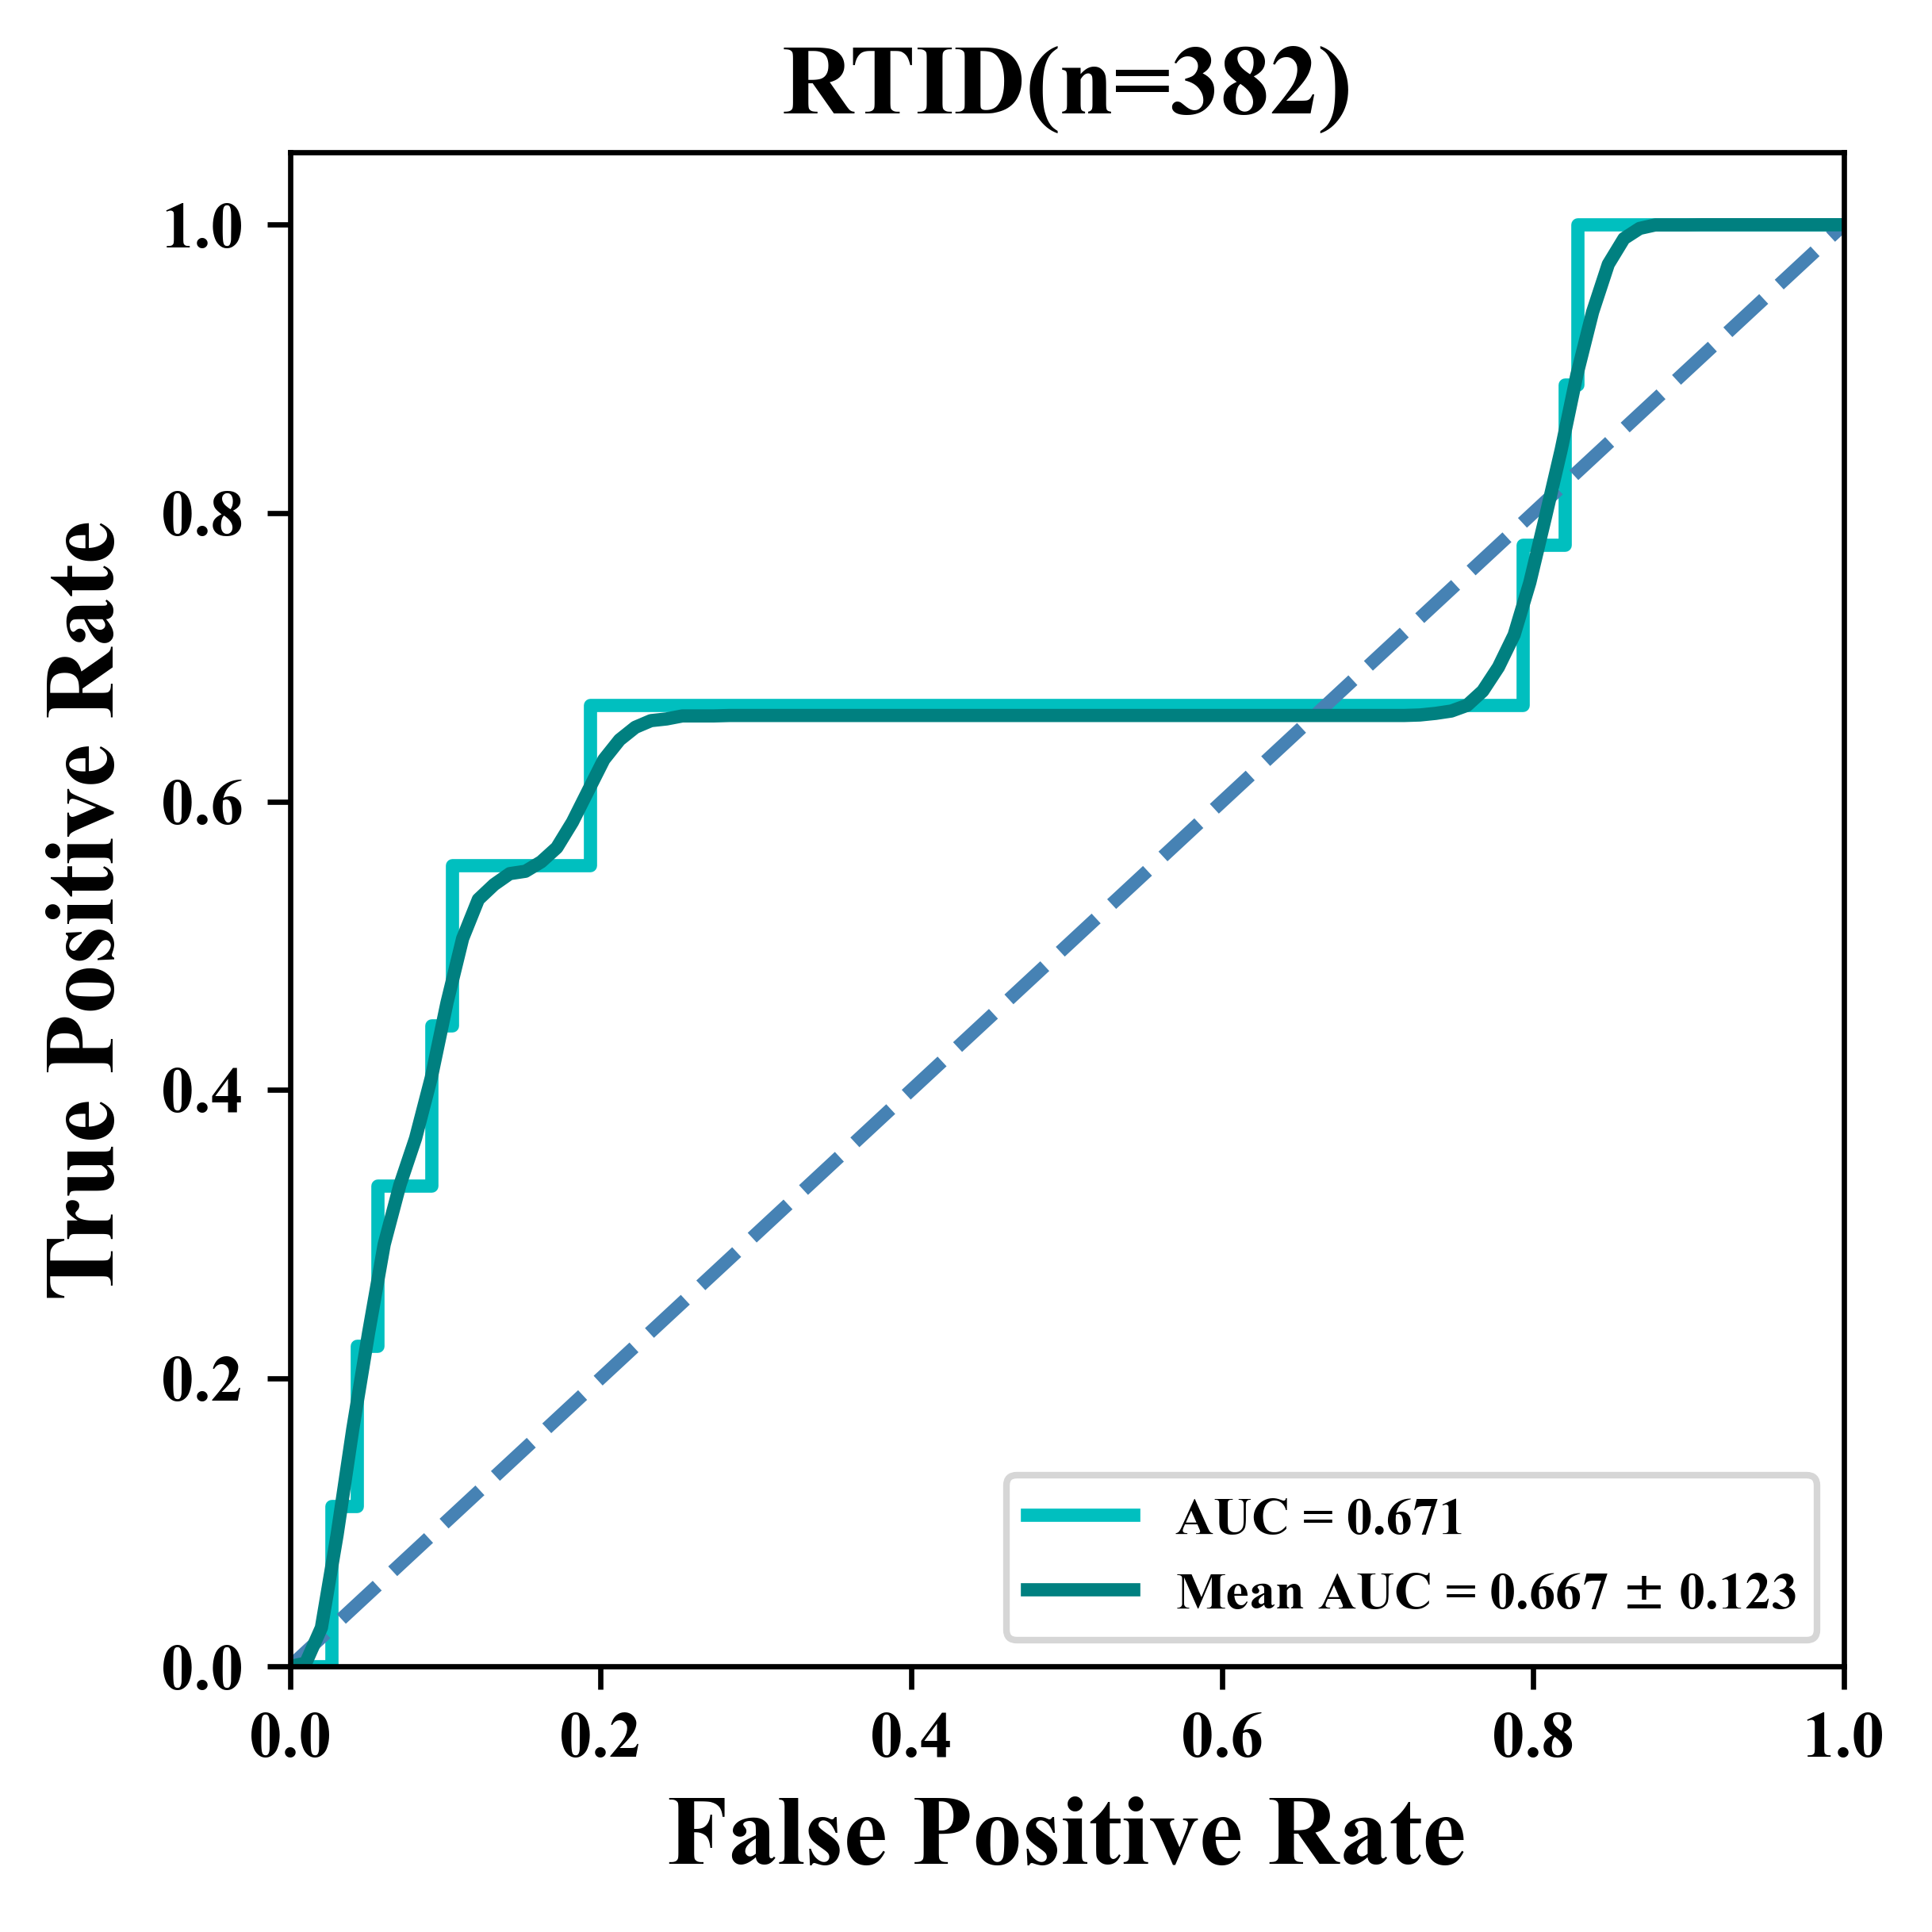

In [40]:
np.random.seed(2025)
plt.figure(figsize=(4, 4),dpi=600)
fpr, tpr, _ = roc_curve(df['al'], df['pres_proba'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='c', lw=2, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='steelblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.ylabel('True Positive Rate',weight='bold',fontproperties = 'Times New Roman',fontsize = 15)
plt.xticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.yticks(rotation=0,fontsize=9,fontproperties = 'Times New Roman',weight='bold')
plt.title('RTID(n=382)',fontproperties = 'Times New Roman',fontsize = 15,weight='bold')
plt.legend(loc='lower right')
n_bootstraps = 1000
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i in range(n_bootstraps):
    indices = resample(np.arange(len(df['al'])))
    fpr_bs, tpr_bs, _ = roc_curve(df['al'].iloc[indices], df['pres_proba'].iloc[indices])
    roc_auc_bs = auc(fpr_bs, tpr_bs)
    interp_tpr = np.interp(mean_fpr, fpr_bs, tpr_bs)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc_bs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

lower_bound = np.percentile(aucs, 2.5)
upper_bound = np.percentile(aucs, 97.5)

plt.plot(mean_fpr, mean_tpr, color='teal', lw=2, label='Mean AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc))

fontdict_prop = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 8,
}
plt.legend(loc="lower right",prop=fontdict_prop)
plt.tight_layout(pad=0.5)
#plt.savefig(r"rtidroc.jpg",dpi=600)
plt.show() 

Figure 3h

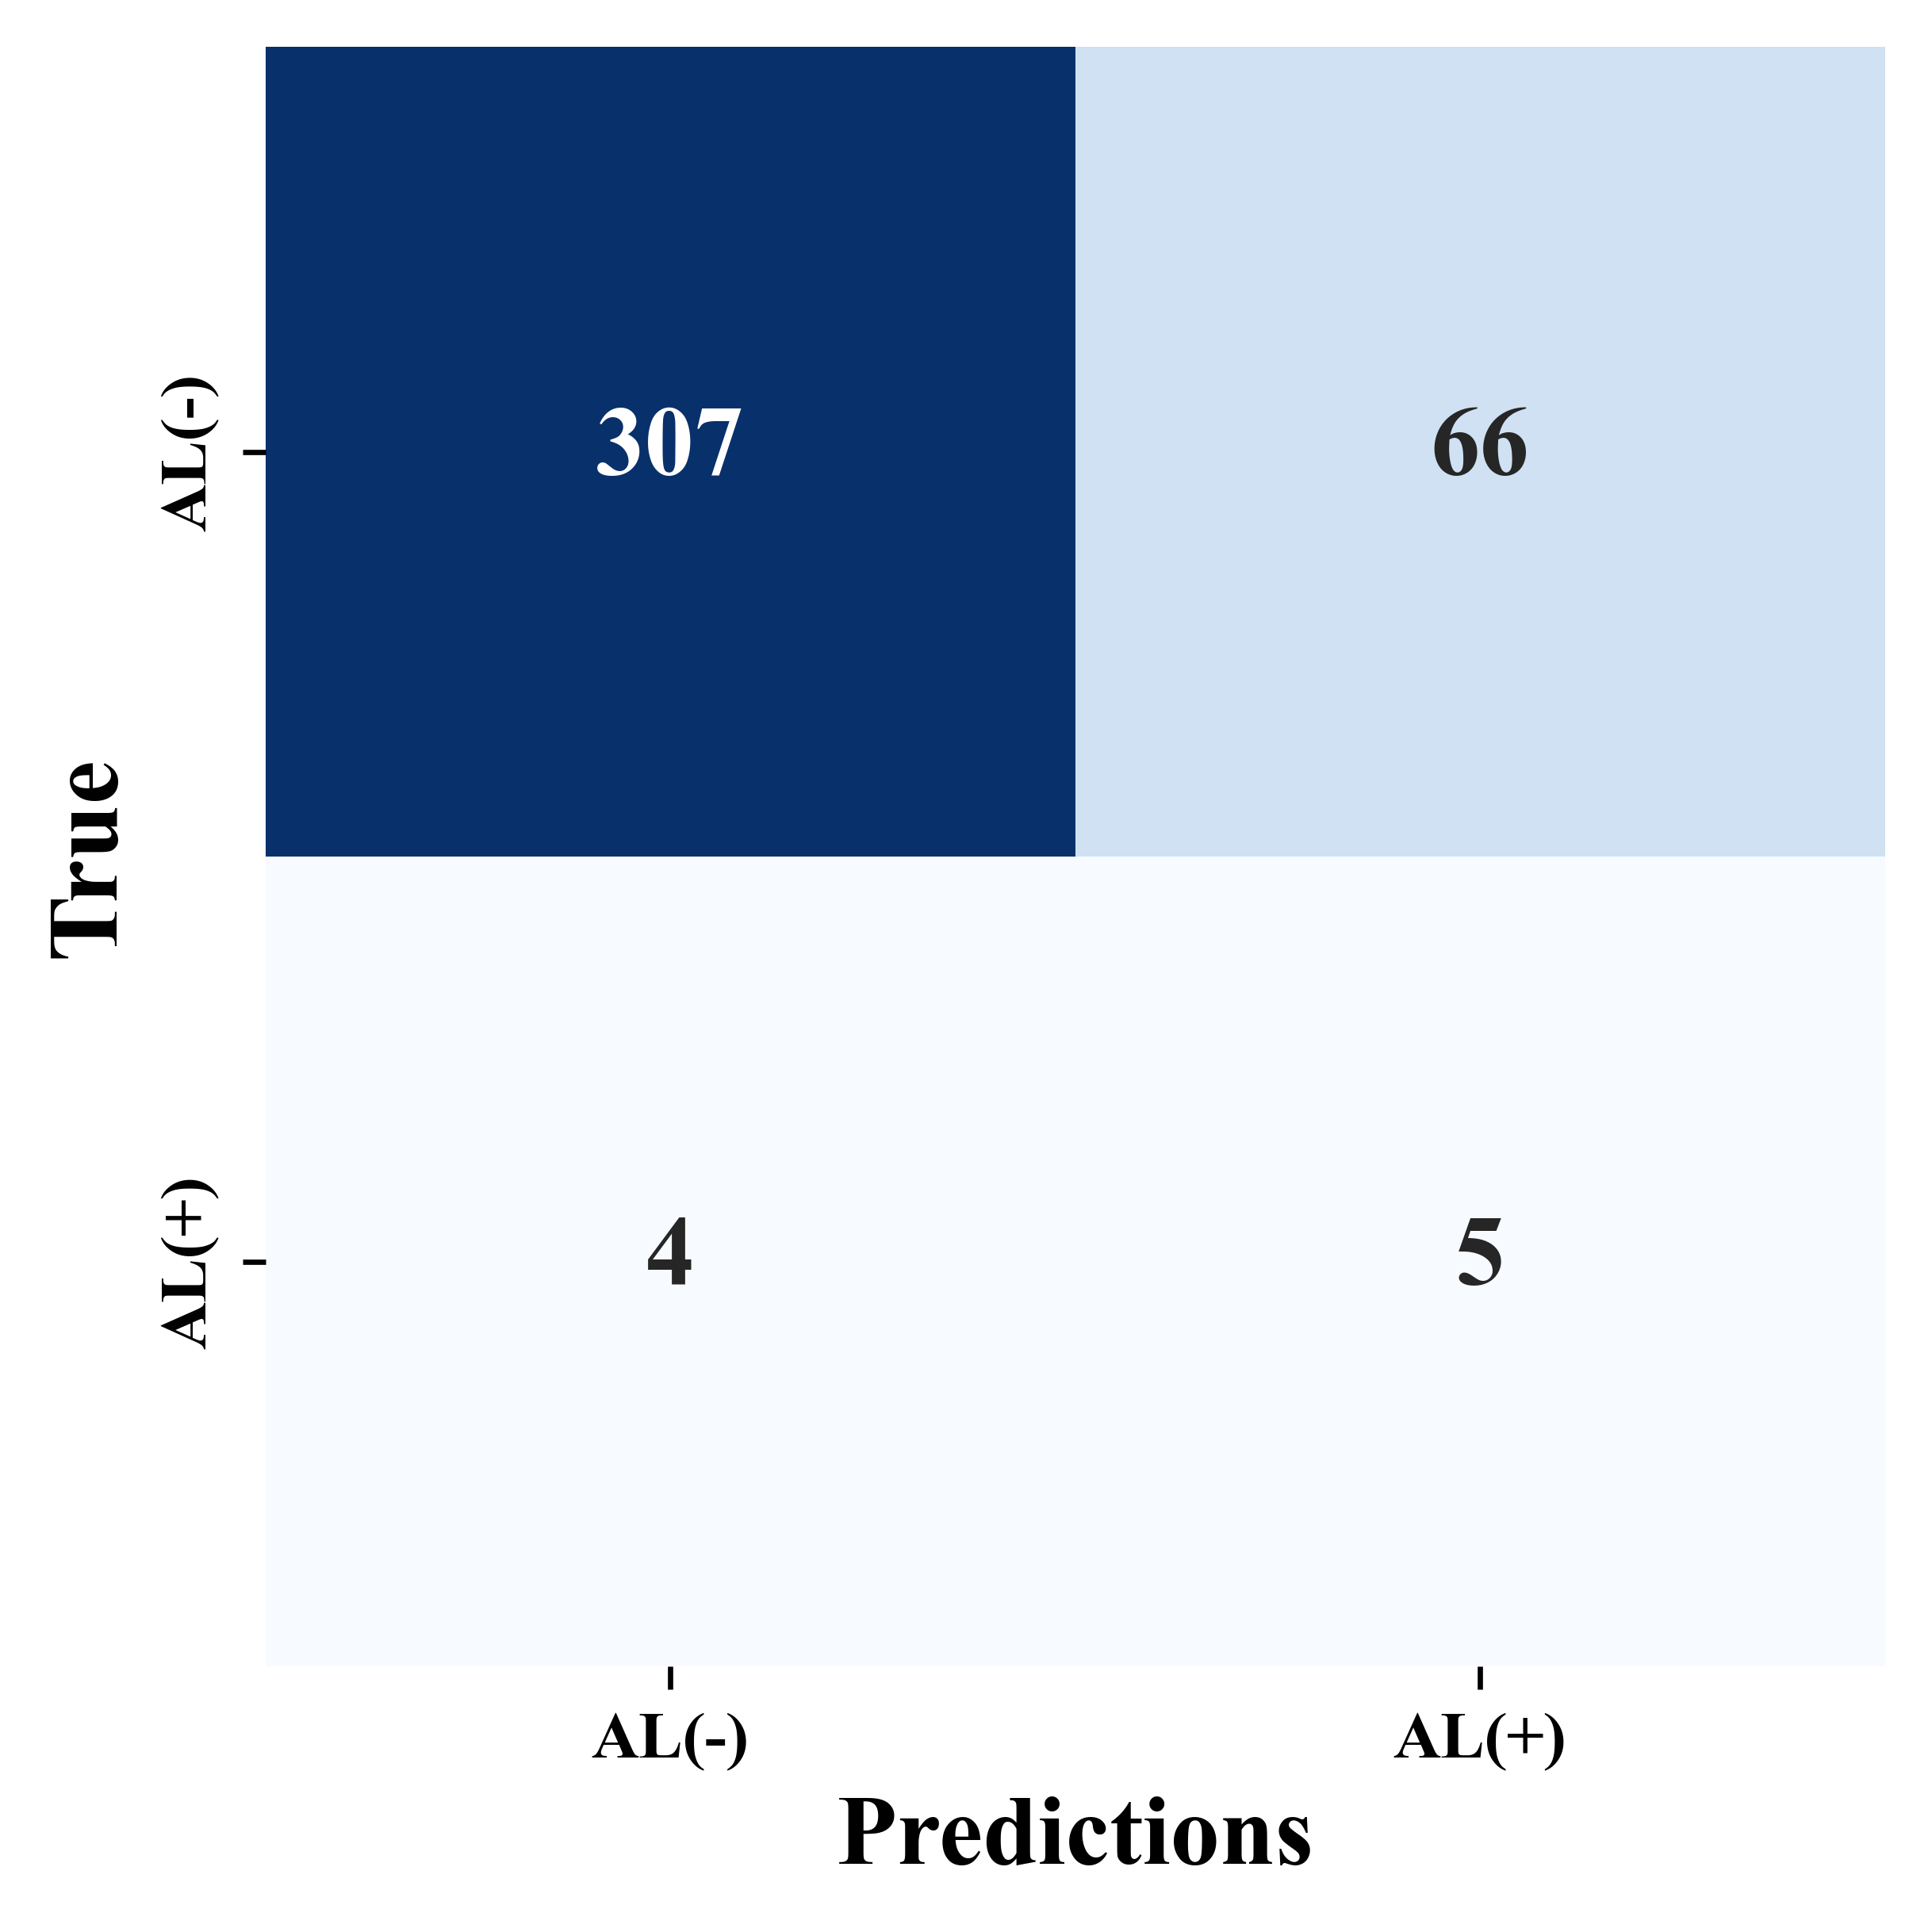

In [43]:
conf_matrix = confusion_matrix(df['al'], df['y_pred1'])
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)
accuracy = accuracy_score(df['al'], df['y_pred1'])
plt.figure(figsize=(4, 4),dpi=600)
sns.heatmap(conf_matrix, 
            annot=True,        
            fmt='d',          
            cmap='Blues', 
            xticklabels=['AL(-)', 'AL(+)'],
            yticklabels=['AL(-)', 'AL(+)'],
            cbar=False,
           annot_kws={
                'size': 15,      
                'fontfamily': 'Times New Roman',  
                'fontweight': 'bold'   
            })      

plt.xlabel('Predictions',fontproperties = 'Times New Roman',weight='bold', fontsize=15)
plt.ylabel('True', fontproperties = 'Times New Roman',weight='bold',fontsize=15)
plt.xticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.tight_layout(pad=0.5)
#plt.savefig(r"rtidhunxiao.jpg",dpi=600)
plt.show() 

Sen: 0.5555555555555556 (95%CI: 0.2000-0.8750)
Spe: 0.8230563002680965 (95%CI: 0.7861-0.8606)
PPV: 0.07042253521126761 (95%CI: 0.0143-0.1316)
NPV: 0.9871382636655949 (95%CI: 0.9744-0.9968)
Accu: 0.8167539267015707 (95%CI: 0.7801-0.8535)


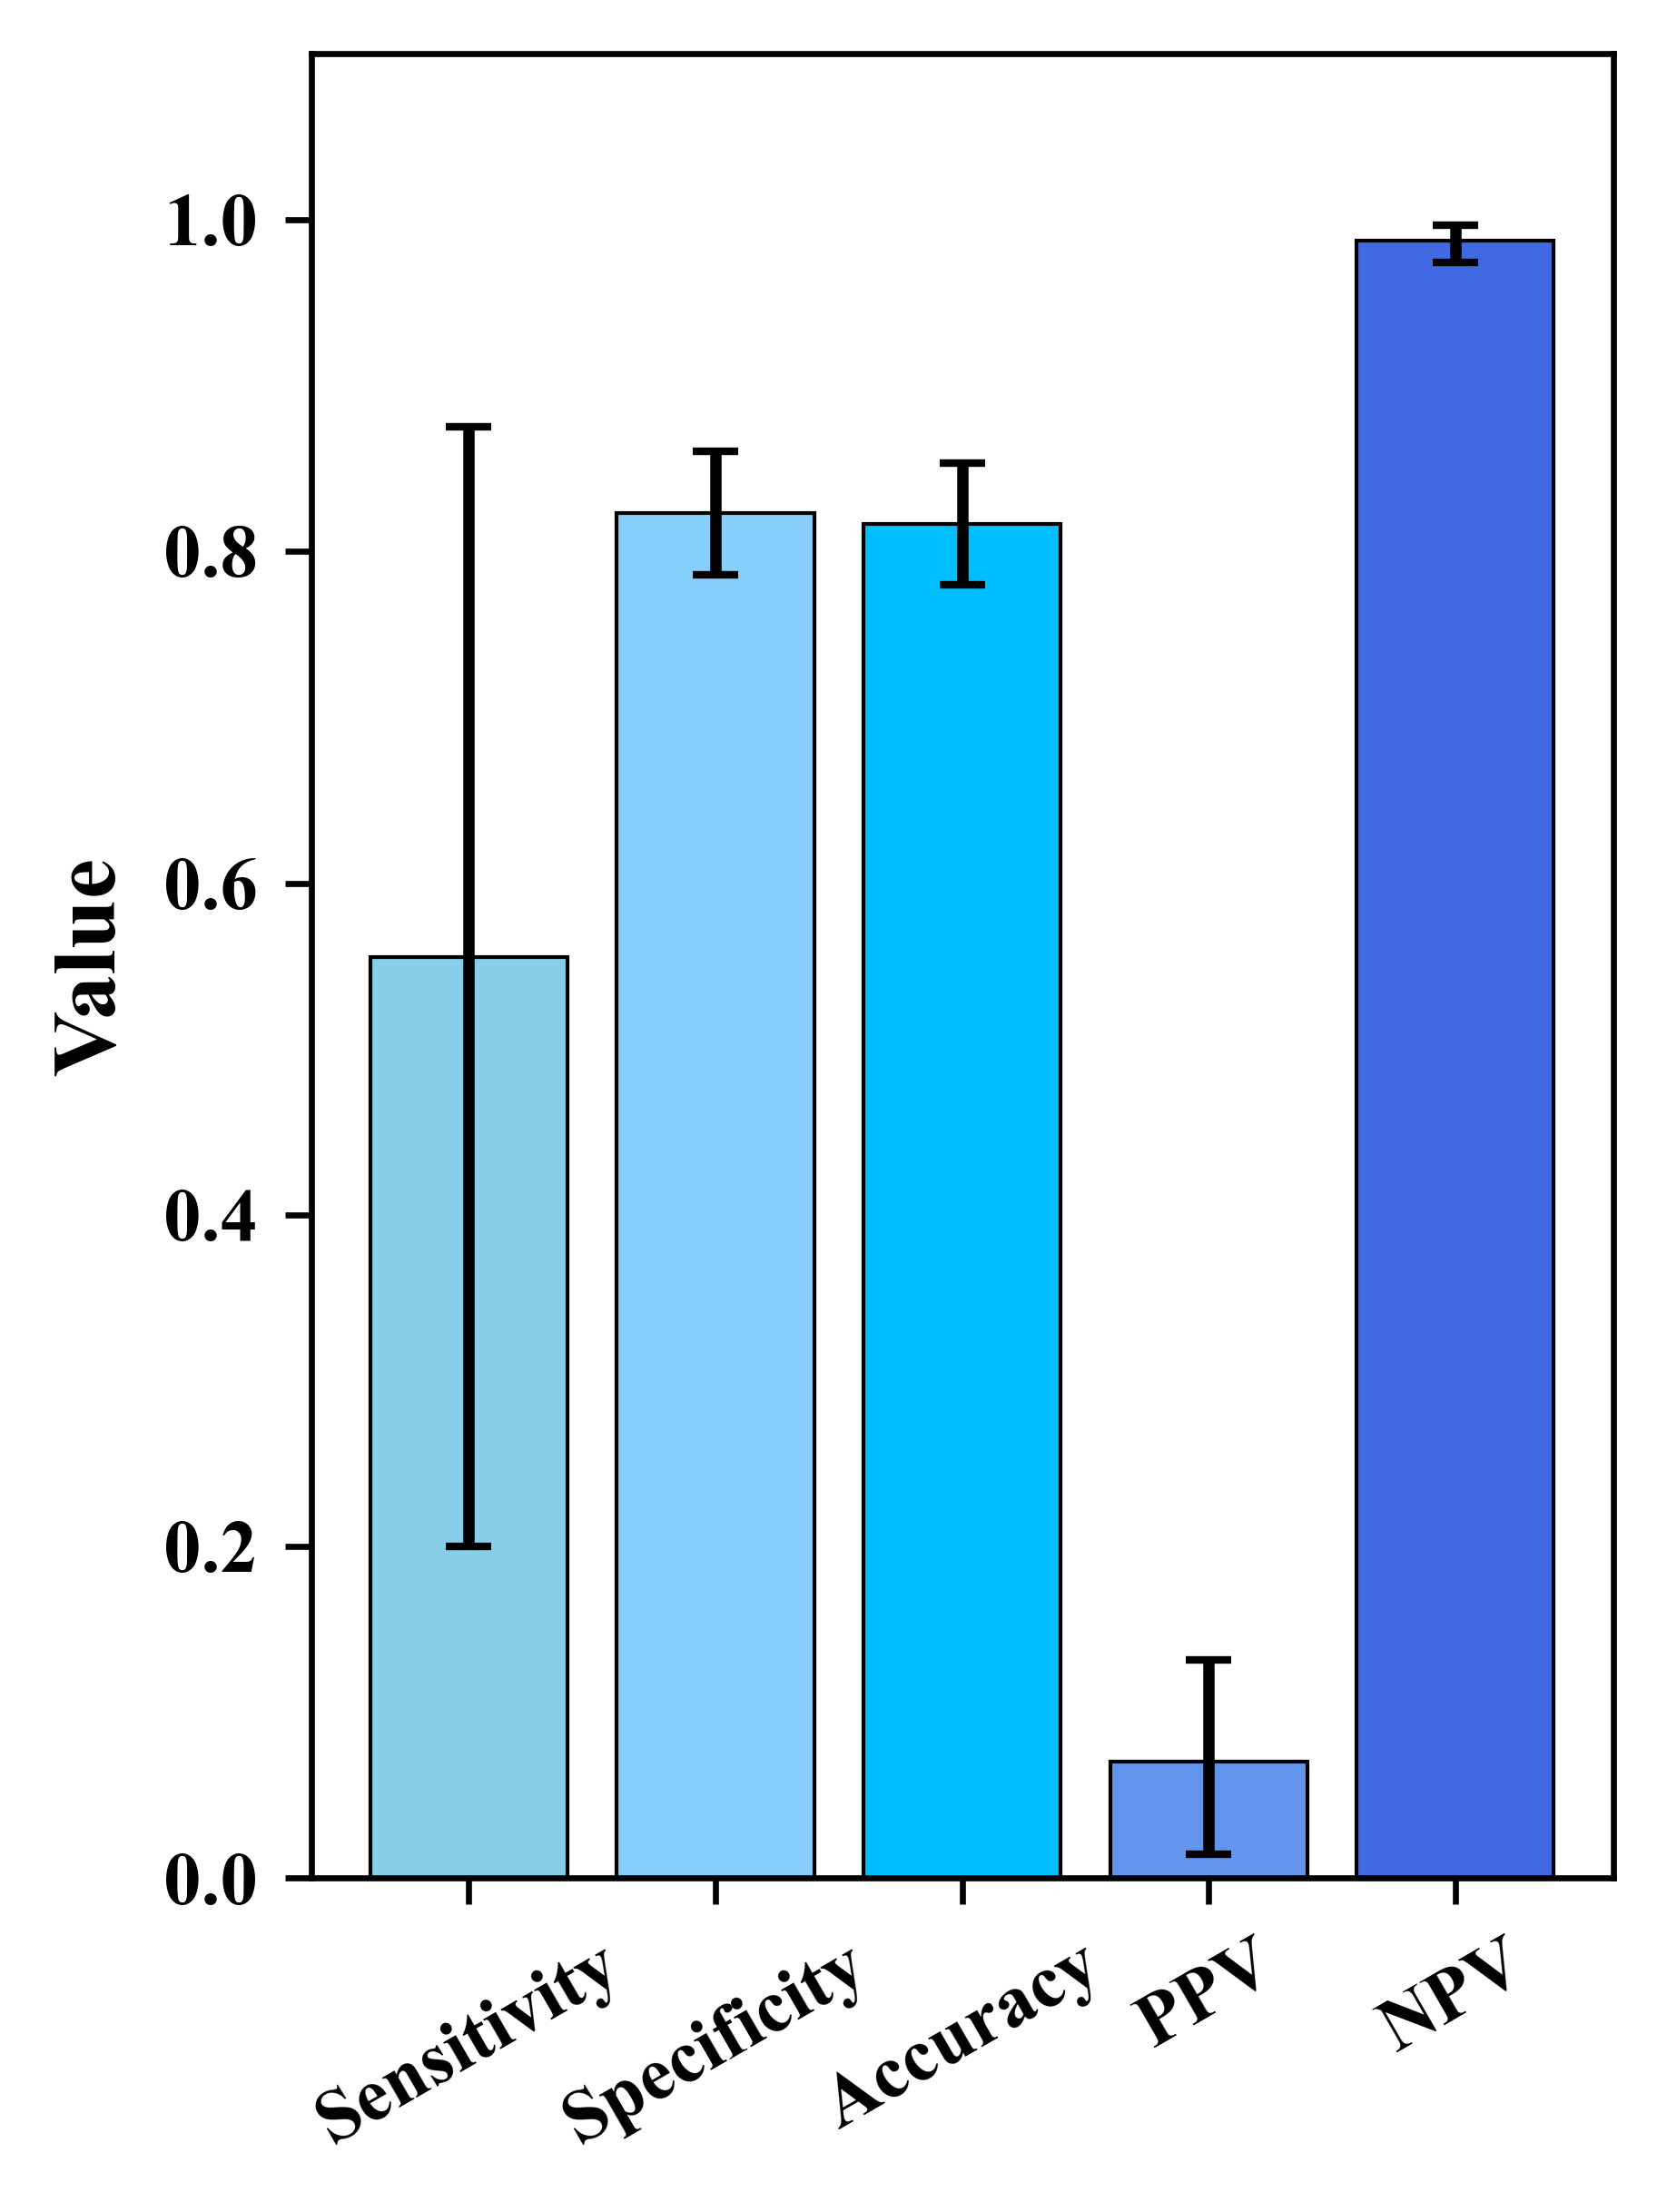

0.5555555555555556 0.8230563002680965 0.07042253521126761 0.9871382636655949 0.8167539267015707


In [45]:
def calculate_95ci_bootstrap(y_true, y_pred, n_iterations=1000):
    sens_list = []
    spec_list = []
    ppv_list = []
    npv_list = []
    acc_list = []
    combined_data = np.column_stack((y_true, y_pred))
    for _ in range(n_iterations):
        boot_sample = resample(combined_data, replace=True, n_samples=len(combined_data))
        boot_y_true = boot_sample[:, 0]
        boot_y_pred = boot_sample[:, 1]
        
        boot_cm = confusion_matrix(boot_y_true, boot_y_pred)
        if boot_cm.shape != (2, 2):  
            continue
        boot_TN = boot_cm[0, 0]
        boot_FP = boot_cm[0, 1]
        boot_FN = boot_cm[1, 0]
        boot_TP = boot_cm[1, 1]
        
        sens = boot_TP / (boot_TP + boot_FN) if (boot_TP + boot_FN) > 0 else 0
        spec = boot_TN / (boot_TN + boot_FP) if (boot_TN + boot_FP) > 0 else 0
        ppv_val = boot_TP / (boot_TP + boot_FP) if (boot_TP + boot_FP) > 0 else 0
        npv_val = boot_TN / (boot_TN + boot_FN) if (boot_TN + boot_FN) > 0 else 0
        acc = accuracy_score(boot_y_true, boot_y_pred)
        
        sens_list.append(sens)
        spec_list.append(spec)
        ppv_list.append(ppv_val)
        npv_list.append(npv_val)
        acc_list.append(acc)

    ci_sensitivity = np.percentile(sens_list, [2.5, 97.5])
    ci_specificity = np.percentile(spec_list, [2.5, 97.5])
    ci_ppv = np.percentile(ppv_list, [2.5, 97.5])
    ci_npv = np.percentile(npv_list, [2.5, 97.5])
    ci_accuracy = np.percentile(acc_list, [2.5, 97.5])
    
    return {
        'sensitivity': ci_sensitivity,
        'specificity': ci_specificity,
        'ppv': ci_ppv,
        'npv': ci_npv,
        'accuracy': ci_accuracy
    }

# 95%CI
ci_results = calculate_95ci_bootstrap(df['al'], df['y_pred1'])
sens_ci = ci_results['sensitivity']
spec_ci = ci_results['specificity']
ppv_ci = ci_results['ppv']
npv_ci = ci_results['npv']
acc_ci = ci_results['accuracy']

print('Sen:', sensitivity, f'(95%CI: {sens_ci[0]:.4f}-{sens_ci[1]:.4f})')
print('Spe:', specificity, f'(95%CI: {spec_ci[0]:.4f}-{spec_ci[1]:.4f})')
print('PPV:', ppv, f'(95%CI: {ppv_ci[0]:.4f}-{ppv_ci[1]:.4f})')
print('NPV:', npv, f'(95%CI: {npv_ci[0]:.4f}-{npv_ci[1]:.4f})')
print('Accu:', accuracy, f'(95%CI: {acc_ci[0]:.4f}-{acc_ci[1]:.4f})')

labels = ['Sensitivity', 'Specificity', 'Accuracy','PPV', 'NPV',]
values = [sensitivity, specificity, accuracy,ppv, npv]

colors = ['skyblue', 'lightskyblue', 'deepskyblue', 'cornflowerblue', 'royalblue'] 

fig, ax = plt.subplots(figsize=(3, 4), dpi=600)

errors = [
    [values[0] - sens_ci[0], sens_ci[1] - values[0]],  
    [values[1] - spec_ci[0], spec_ci[1] - values[1]],  
    [values[2] - acc_ci[0], acc_ci[1] - values[2]],    
    [values[3] - ppv_ci[0], ppv_ci[1] - values[3]],    
    [values[4] - npv_ci[0], npv_ci[1] - values[4]]     
]

yerr = np.array(errors).T

bars = ax.bar(labels, values, color=colors, yerr=yerr, capsize=3, edgecolor='black', linewidth=0.5)


ax.set_ylabel('Value',fontproperties = 'Times New Roman',weight='bold',fontsize=12)
plt.xticks(rotation=30,fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.yticks(fontproperties = 'Times New Roman',weight='bold',fontsize=10,)
plt.ylim(0,1.1)

ci_pairs = [sens_ci, spec_ci, acc_ci, ppv_ci, npv_ci]  

plt.tight_layout(pad=0.5)
#plt.savefig(r"rtidpara.jpg",dpi=600)
plt.show()

Figure 3i

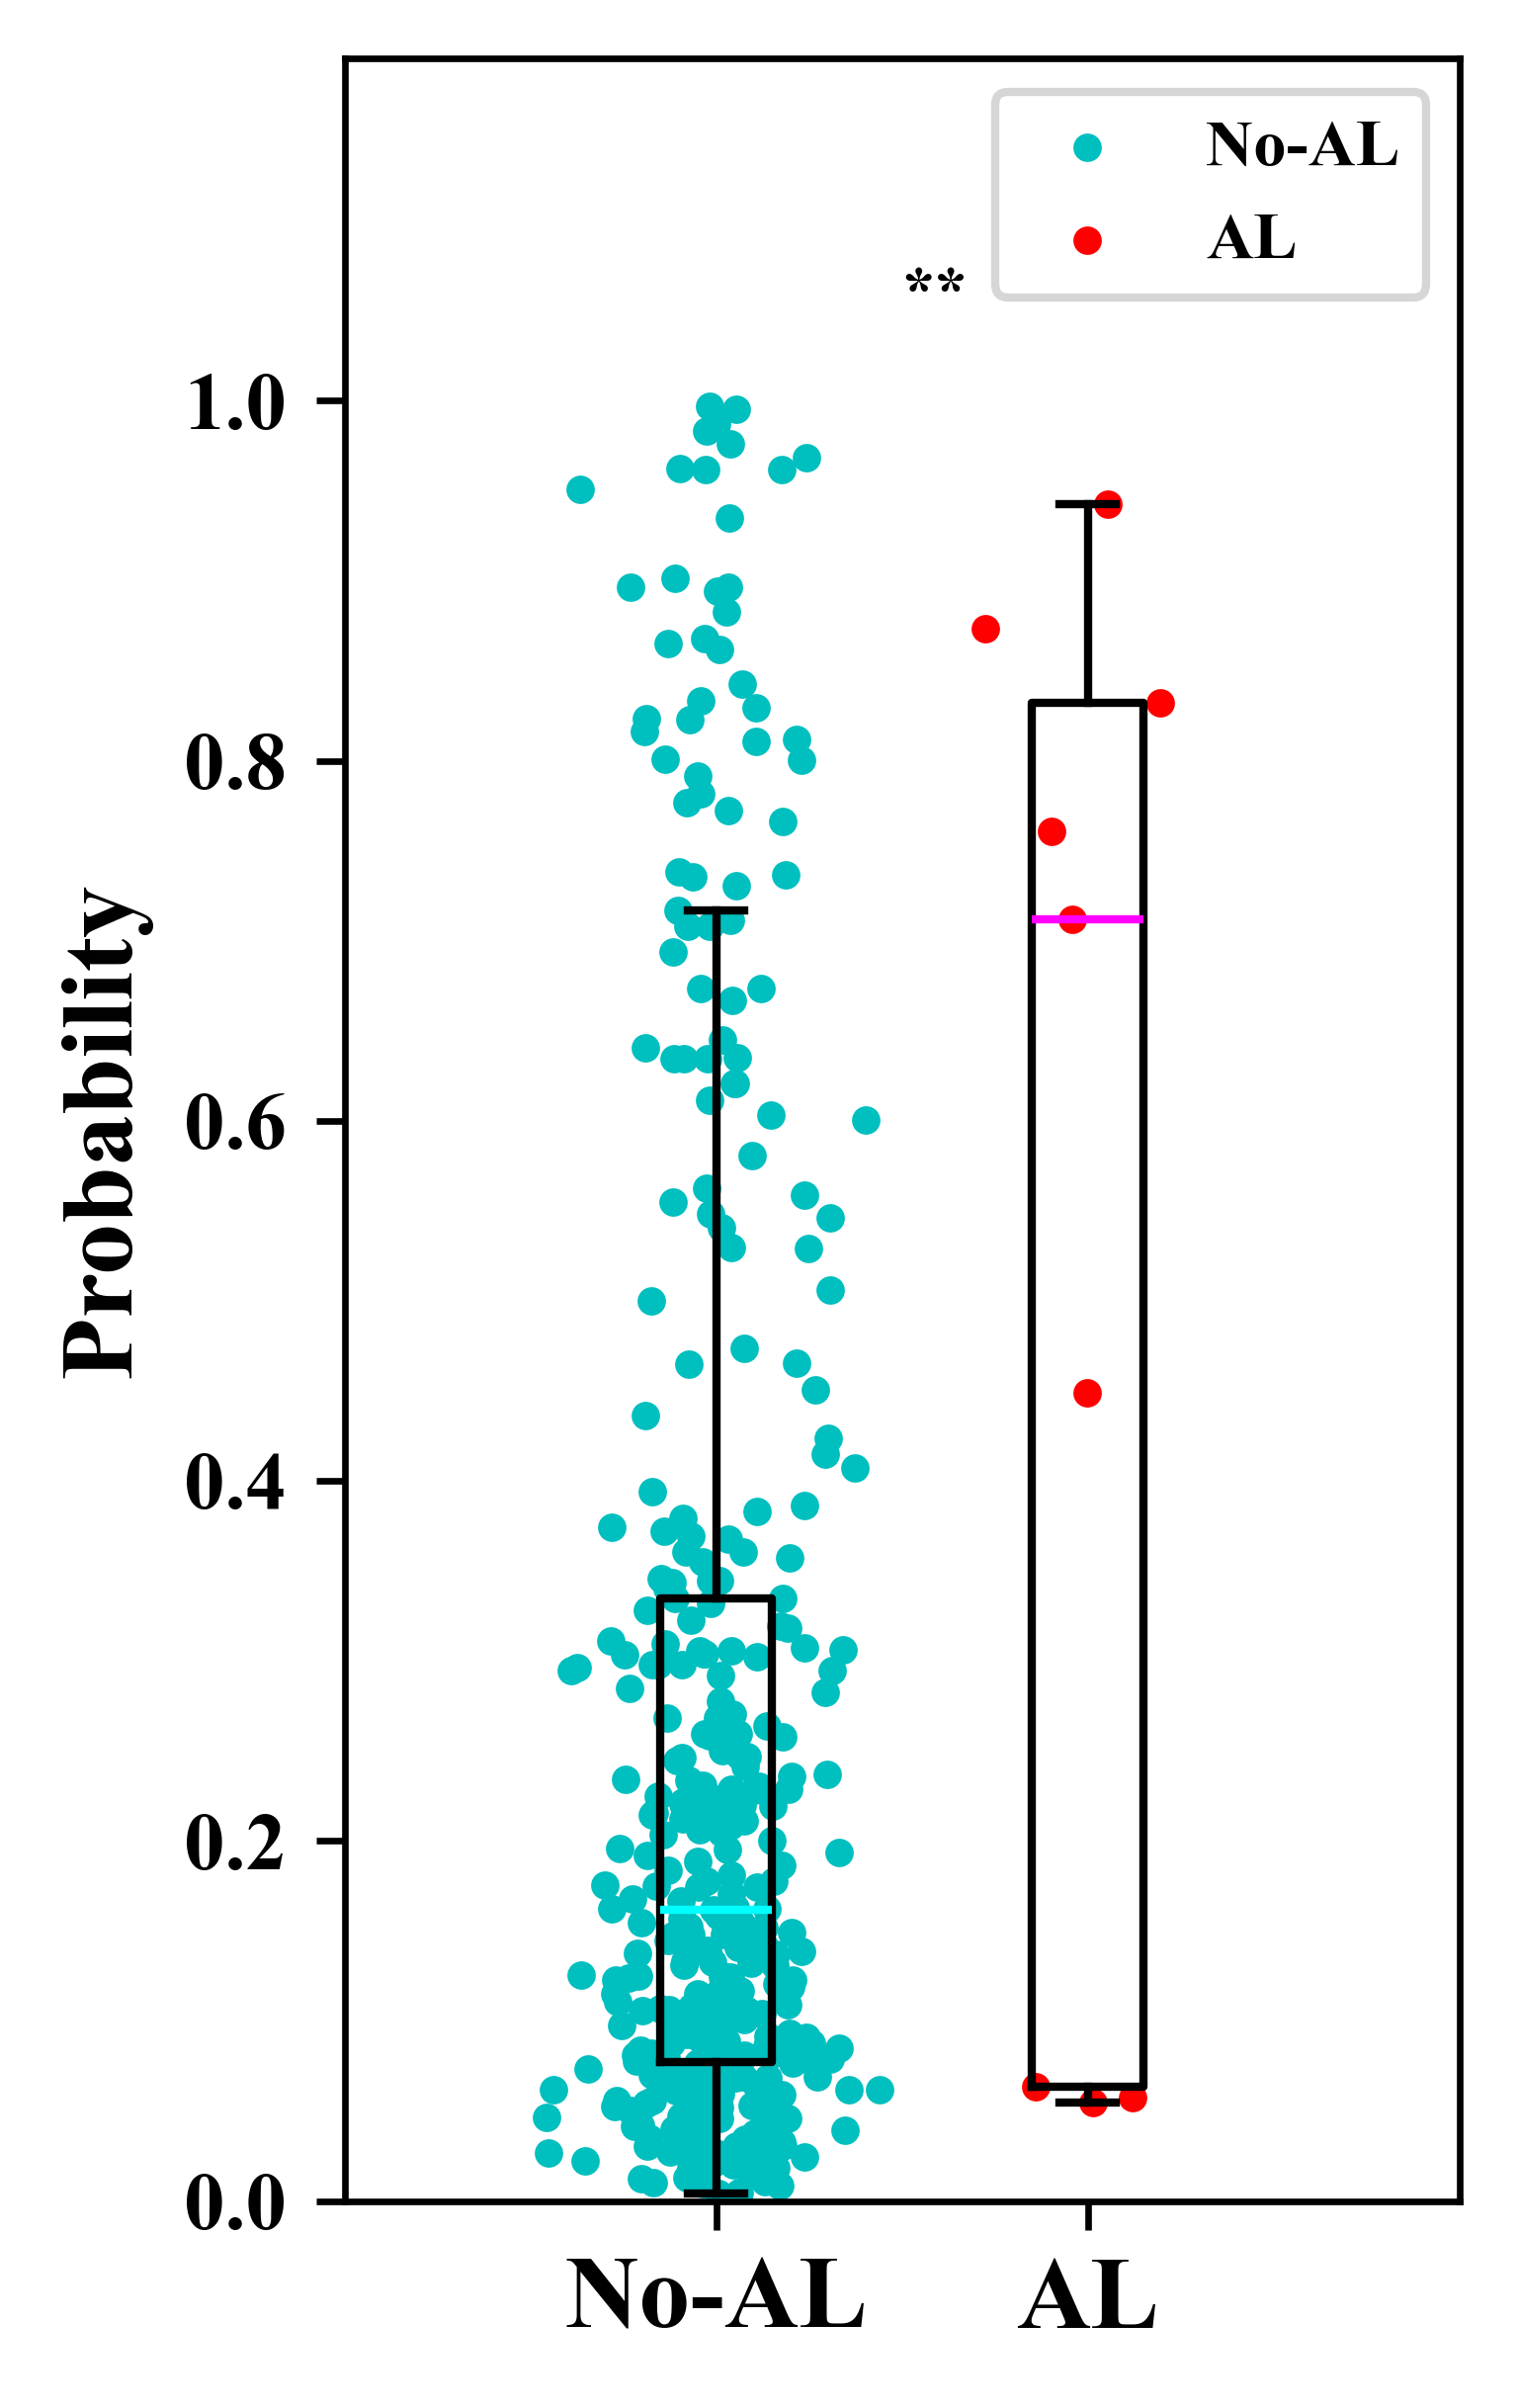

In [50]:
df = pd.read_excel(r'rtid.xlsx')
data1 = [df['pres_proba'][df['al'] == 0], df['pres_proba'][df['al'] == 1]]
positions = []
gap_between_pairs = 0.5  
for i in range(2):
    base_pos = i * gap_between_pairs + 1
    positions.append(base_pos)
plt.figure(figsize=(2.5, 4), dpi=600)

bp = plt.boxplot(data1, positions=positions, showfliers=False)

for patch in bp['boxes']:
    patch.set_color('black')

new_positions = positions

custom_labels = ['No-AL', 'AL']
plt.xticks(new_positions, custom_labels)

median_colors = ['cyan', 'magenta']
for i, median in enumerate(bp['medians']):
    median.set_color(median_colors[i % 2])


scatter_colors = ['c', 'red']


for i, d in enumerate(data1):
    x = np.random.normal(positions[i], 0.075, size=len(d))
    label = 'No-AL' if scatter_colors[i] == 'c' else 'AL'
    plt.scatter(x, d, color=scatter_colors[i], alpha=1, s=6, label=label if i < 2 else "")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
fontdict_prop = {'family': 'Times New Roman',
                 'weight': 'bold',
                 'size': 8,
                 }
plt.legend(by_label.values(), by_label.keys(), prop=fontdict_prop)

plt.ylabel('Probability', fontproperties='Times New Roman', fontsize=12.5, weight='bold')
plt.xticks(rotation=0,  fontproperties='Times New Roman', fontsize=12.5,weight='bold')
plt.yticks(rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')
plt.ylim(0, 1.19)
plt.text(1.25,1.05, '**',rotation=0, fontsize=8, fontproperties='Times New Roman', weight='bold')
plt.tight_layout(pad=0.5)
#plt.savefig(r"rtidproba.jpg",dpi=600)
plt.show()